# Model Interpretability

Abstract

Customer churn has become a major problem in banking industry and banks have always tried to track customer interaction with the company to detect early warning signs in customer’s behavior.In this notebook we perform classification on whether a customer would be exit or not based on some factors and patterns.

**The Bank Customer Churn dataset contains the following features:**

1.CustomerID

2.Credit Score

3.Country

4.Gender

5.Age

6.Tenure

7.Balance

8.Product Number

9.Credit Card

10.Active Member

11.Estimated Salary

12.Churn

In [154]:
!pip install shap

In [155]:
!pip install category_encoders

In [156]:
!pip install eli5

# Importing packages and dataset

In [61]:
import warnings
import pandas as pd
from pandas.api.types import is_numeric_dtype

import numpy as np

from scipy import stats
from statsmodels.stats import weightstats as stests

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import statsmodels.api as sm
from statsmodels.formula.api import ols


from sklearn.preprocessing import LabelEncoder as le
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler as rbScaler

from sklearn.linear_model import LogisticRegression as lgrClassifier
from sklearn import metrics

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [157]:
#Loading the Data

df = pd.read_csv("https://raw.githubusercontent.com/anshvaghela2099/INFO6105_DSEM/main/Bank_Customer_Churn_Prediction.csv", low_memory=False)

In [158]:
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split

In [159]:
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [160]:
df.shape

(10000, 12)

# Checking for missing data

In [161]:
df.isnull().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

**There are NO missing values in the dataset, hence no imputation method is needed**

In [162]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB



**Categorical Columns:**

1.country

2.gender

**Numerical Columns:**

1.customer_id

2.credit_score

3.age

4.tenure

5.balance

6.products number

7.credit card

8.active member

9.estimated salary

10.churn

In [163]:
df.describe()

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


**Dropping column Customer_ID, it is a randomly assigned number which will not have impact on our analysis**

In [164]:
df = df.drop(["customer_id"],axis = 1)

In [165]:
df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Generating Data Summary
Entroy is used to understand the distribution of data in the features

In [166]:
def summarytable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    summary['Sample Value'] = df.loc[0].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=10),2)
    return summary

summarytable(df)

Dataset Shape: (10000, 11)


,Name,dtypes,Missing,Uniques,Sample Value,Entropy
0,credit_score,int64,0,460,619,2.55
1,country,object,0,3,France,0.45
2,gender,object,0,2,Female,0.30
3,age,int64,0,70,42,1.60
4,tenure,int64,0,11,2,1.03
5,balance,float64,0,6382,0.0,2.71
6,products_number,int64,0,4,1,0.36
7,credit_card,int64,0,2,1,0.26
8,active_member,int64,0,2,1,0.30
9,estimated_salary,float64,0,9999,101348.88,4.00


# Numerical and Categorical Columns

In [167]:
#numeric columns
num_cols = df.select_dtypes('number').columns
num_cols

Index(['credit_score', 'age', 'tenure', 'balance', 'products_number',
       'credit_card', 'active_member', 'estimated_salary', 'churn'],
      dtype='object')

In [168]:
#categorical columns
catg_cols = df.select_dtypes('object').columns
catg_cols

Index(['country', 'gender'], dtype='object')

Numerical Columns

credit_score

age

tenure

balance

products_number

credit_card

active_member

estimated salary

churn

Categorical Columns

country

gender

# Column Distribution

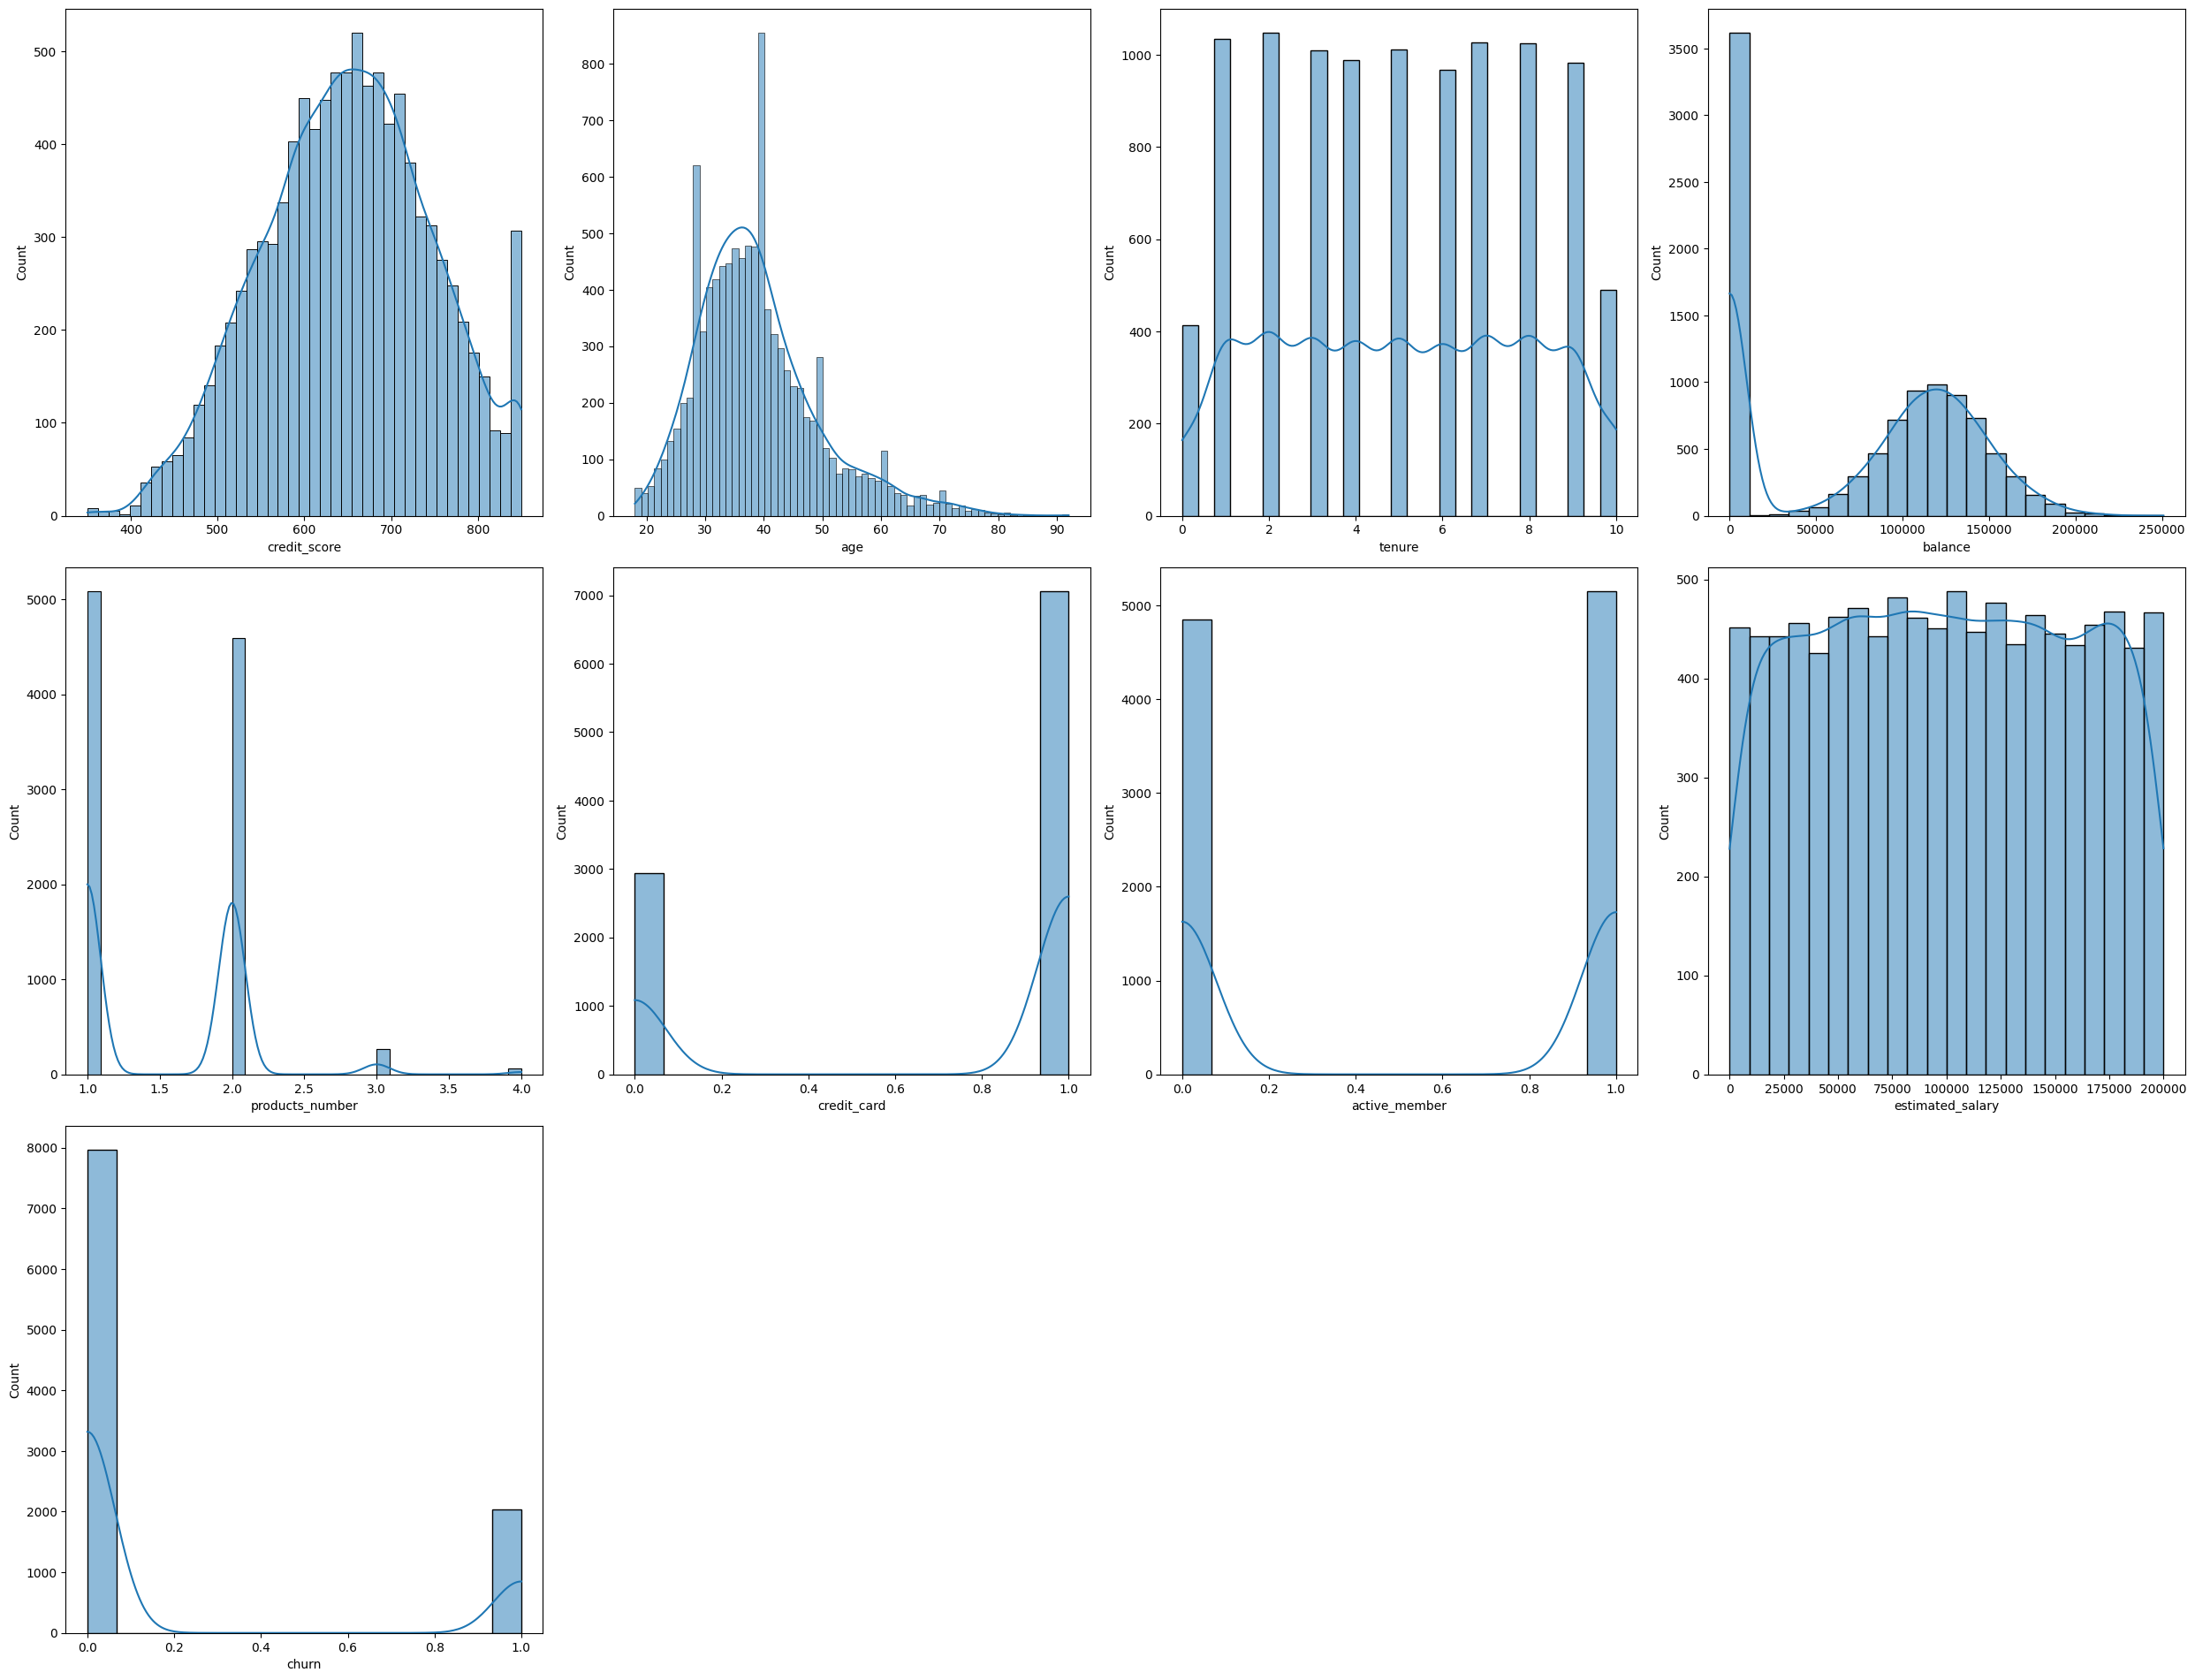

In [169]:
rows = 4
cols = 4
counter = 1
plt.rcParams['figure.figsize'] = [25,25]
for row in range(rows):
    for col in range(cols):
        if counter <= len(num_cols):
            plt.subplot(rows, cols, counter)
            sns.histplot(df[num_cols[counter - 1]], kde=True)
        counter += 1
plt.tight_layout()
plt.show()

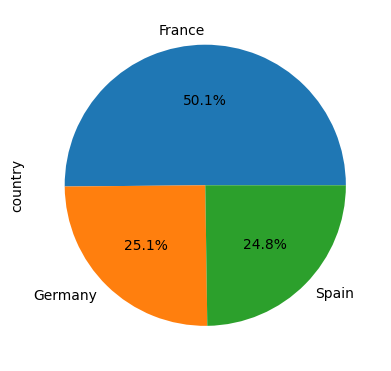

In [75]:
df['country'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(4, 4))
plt.tight_layout()
plt.show()

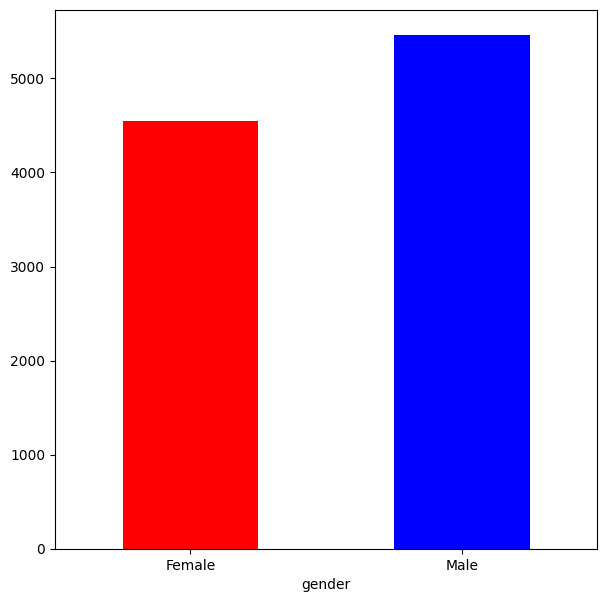

In [76]:
#gender distribution
plt.figure(figsize = (7,7))
plt_room_types = df.groupby("gender").size().plot.bar(x="gender", y= 'size', rot = 0, color=['red', 'blue'])

# Encoding Categorical Features

In [170]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [171]:
le = LabelEncoder()

for column in df.columns:
    # Fit the label encoder to the dataframe column
    le.fit(df[column])
    # Replace the dataframe column with the encoded values
    df[column] = le.transform(df[column])

print(df)

      credit_score  country  gender  age  tenure  balance  products_number  \
0              228        0       0   24       2        0                0   
1              217        2       0   23       1      743                0   
2              111        0       0   24       8     5793                2   
3              308        0       0   21       1        0                1   
4              459        2       0   25       2     3696                0   
...            ...      ...     ...  ...     ...      ...              ...   
9995           380        0       1   21       5        0                1   
9996           125        0       1   17      10      124                0   
9997           318        0       0   18       7        0                0   
9998           381        1       1   24       3      427                1   
9999           401        0       0   10       4     4112                0   

      credit_card  active_member  estimated_salary  churn  
0  

In [172]:
df['country'].unique()

array([0, 2, 1])

In [173]:
df.columns

Index(['credit_score', 'country', 'gender', 'age', 'tenure', 'balance',
       'products_number', 'credit_card', 'active_member', 'estimated_salary',
       'churn'],
      dtype='object')

In [174]:
df.describe()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,259.584600,0.746300,0.545700,20.920600,5.012800,2036.788100,0.530200,0.70550,0.515100,4998.621200,0.203700
std,96.496107,0.827529,0.497932,10.482065,2.892174,2125.232536,0.581654,0.45584,0.499797,2886.711202,0.402769
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,193.000000,0.000000,0.000000,14.000000,3.000000,0.000000,0.000000,0.00000,0.000000,2498.750000,0.000000
50%,261.000000,0.000000,1.000000,19.000000,5.000000,1383.500000,0.000000,1.00000,1.000000,4998.500000,0.000000
75%,327.000000,1.000000,1.000000,26.000000,7.000000,3882.250000,1.000000,1.00000,1.000000,7498.250000,0.000000
max,459.000000,2.000000,1.000000,69.000000,10.000000,6381.000000,3.000000,1.00000,1.000000,9998.000000,1.000000


In [175]:
target.shape

(10000,)

In [176]:
features = df[["credit_score","country","gender","age","tenure","balance","products_number","credit_card","active_member","estimated_salary"]]

In [177]:
features.shape

(10000, 10)

In [178]:
datasetClean = pd.concat([features,target], axis = 1, join = 'inner')

In [179]:
datasetClean.shape

(10000, 11)

In [180]:
df = df.reset_index()

In [181]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

Replacing any infinite values in the DataFrame df with NaN and making changes to the original DataFrame df.

In [182]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=42)

In [183]:
X_train.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary
9254,295,0,1,14,6,0,1,1,1,8963
1561,241,1,1,24,4,3167,1,1,1,9782
1670,168,2,1,6,3,2762,0,1,0,4291
6087,170,0,0,9,9,4516,0,1,0,7686
6669,126,0,1,38,9,4968,0,0,0,1936


In [184]:
y_train.shape

(8000,)

# Q1. Fit a linear model and interpret the regression coefficients

In [185]:
import statsmodels.api as sm

lin_reg = sm.OLS(y_train,X_train).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  churn   R-squared (uncentered):                   0.309
Model:                            OLS   Adj. R-squared (uncentered):              0.308
Method:                 Least Squares   F-statistic:                              357.9
Date:                Mon, 18 Mar 2024   Prob (F-statistic):                        0.00
Time:                        02:53:28   Log-Likelihood:                         -3541.8
No. Observations:                8000   AIC:                                      7104.
Df Residuals:                    7990   BIC:                                      7174.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
credit_score      -4.29e-06   3.71e-05     -0.116      0.908   -7.69e-05    6.84e-05
country              0.0184      0.005      3.651      0.000       0.009       0.028
gender              -0.0711      0.008     -8.606      0.000      -0.087      -0.055
age                  0.0119      0.000     32.019      0.000       0.011       0.013
tenure            -4.27e-05      0.001     -0.031      0.975      -0.003       0.003
balance           1.721e-05   1.99e-06      8.644      0.000    1.33e-05    2.11e-05
products_number     -0.0080      0.007     -1.092      0.275      -0.022       0.006
credit_card          0.0098      0.009      1.117      0.264      -0.007       0.027
active_member       -0.1389      0.008    -16.602      0.000      -0.155      -0.123
estimated_salary  2.945e-06   1.37e-06      2.146      0.032    2.55e-07    5.64e-06
==============================================================================
Omnibus:                     1184.597   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1799.316
Skew:                           1.159   Prob(JB):                         0.00
Kurtosis:                       3.159   Cond. No.                     1.30e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.3e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Considering the significance value of 0.05

credit_score has the p-value 0.908, which is lesser and hence it is a non-significant feature.

country has the p-value 0, which is lesser and hence it is a significant feature.

gender has the p-value 0, which is lesser and hence it is a significant feature.

age has the p-value 0, which is lesser and hence it is a significant feature.

tenure has the p-value 0.957, which is which is slightly more than the threshold value of 0.05 and hence it is a non-significant feature.

balance has the p-value 0, which is lesser and hence it is a significant feature.

products_number has the p-value 0.275, which is lesser and hence it is a non-significant feature.

credit_card has the p-value 0.547, which is greater than the significant value i.e 0.05 and hence it is a non-significant feature.

active_member has the p-value 0, which is lesser and hence it is a significant feature.

estimated_salary has the p-value 0.032, which is greater and hence it is a significant feature.

# Permutation Importance

In [141]:
!pip install eli5

In [144]:
import eli5

In [186]:
from eli5.sklearn import PermutationImportance

In [187]:
def get_permutation_importance(df):
    X = df[["credit_score","gender","country","age","tenure","balance","products_number","credit_card","active_member","estimated_salary"]]
    y = df[["churn"]]
    X_t, X_test, y_t, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
    X_train, X_val, y_train, y_val = train_test_split(X_t, y_t, test_size=0.10, random_state=1)
    # Create linear regression object
    model = linear_model.LinearRegression()
    model.fit(X_train,y_train)
    pi = PermutationImportance(model, random_state=1).fit(X_test, y_test)
    return eli5.show_weights(pi, feature_names = X_test.columns.tolist())


In [188]:
get_permutation_importance(df)

Weight,Feature
0.1789 ± 0.0159,age
0.0598 ± 0.0084,active_member
0.0198 ± 0.0070,gender
0.0154 ± 0.0072,balance
0.0014 ± 0.0004,credit_score
0.0010 ± 0.0025,country
0.0008 ± 0.0005,products_number
0.0007 ± 0.0008,tenure
0.0002 ± 0.0009,estimated_salary
-0.0006 ± 0.0006,credit_card


age is the most important feature to predict the target variable churn followed by active_member, gender and balance.

In [148]:
lr_pred = lin_reg.predict(X_test)

In [189]:
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.metrics import r2_score

In [153]:
print('Test')
print('MAE: %f'% mean_absolute_error(y_test, lr_pred))
print('RMSE: %f'% np.sqrt(mean_squared_error(y_test, lr_pred)))
print('R2 %f' % r2_score(y_test, lr_pred))

Test
MAE: 0.283642
RMSE: 0.369368
R2 0.135887


P > |t| has a value less than 0.1 for country,gender,age,balance,active_member,estimated_salary indicating that these variables are important in predicting the price.

# Q2. Fit a tree-based model and interpret the nodes

In [190]:
from sklearn.tree import DecisionTreeRegressor
DTree=DecisionTreeRegressor(max_depth=3, random_state=1234)
DTree.fit(X_train,y_train)

DTree_score = DTree.score(X_test, y_test)
print(DTree_score)

0.25323036635378915


The code creates an instance of the DecisionTreeRegressor class named DTree. The max_depth parameter is set to 3, which limits the maximum depth of the decision tree to 3 levels which helps in preventing overfitting

In [191]:
from sklearn.metrics import r2_score,mean_absolute_error
def model_sel(model):
    y_pred = model.predict(X_test)
    print("MODEL EVALUATION")
    print("\nr2_score of the model: ")
    print(r2_score(y_test,y_pred))

In [199]:
# Model Evaluation on DecisionTreeRegressor
print("DECISION TREE REGRESSION: ")
model_sel(DTree)

DECISION TREE REGRESSION: 
MODEL EVALUATION

r2_score of the model: 
0.25323036635378915


In [200]:
prediction_tree = DTree.predict(X_test)

[Text(0.5, 0.875, 'age <= 26.5\nsquared_error = 0.163\nsamples = 8000\nvalue = 0.206'),
 Text(0.25, 0.625, 'products_number <= 1.5\nsquared_error = 0.114\nsamples = 6130\nvalue = 0.131'),
 Text(0.125, 0.375, 'products_number <= 0.5\nsquared_error = 0.102\nsamples = 5987\nvalue = 0.115'),
 Text(0.0625, 0.125, 'squared_error = 0.15\nsamples = 2952\nvalue = 0.184'),
 Text(0.1875, 0.125, 'squared_error = 0.047\nsamples = 3035\nvalue = 0.049'),
 Text(0.375, 0.375, 'balance <= 148.0\nsquared_error = 0.157\nsamples = 143\nvalue = 0.804'),
 Text(0.3125, 0.125, 'squared_error = 0.239\nsamples = 56\nvalue = 0.607'),
 Text(0.4375, 0.125, 'squared_error = 0.064\nsamples = 87\nvalue = 0.931'),
 Text(0.75, 0.625, 'active_member <= 0.5\nsquared_error = 0.247\nsamples = 1870\nvalue = 0.448'),
 Text(0.625, 0.375, 'age <= 33.5\nsquared_error = 0.22\nsamples = 804\nvalue = 0.673'),
 Text(0.5625, 0.125, 'squared_error = 0.248\nsamples = 502\nvalue = 0.55'),
 Text(0.6875, 0.125, 'squared_error = 0.108\nsam

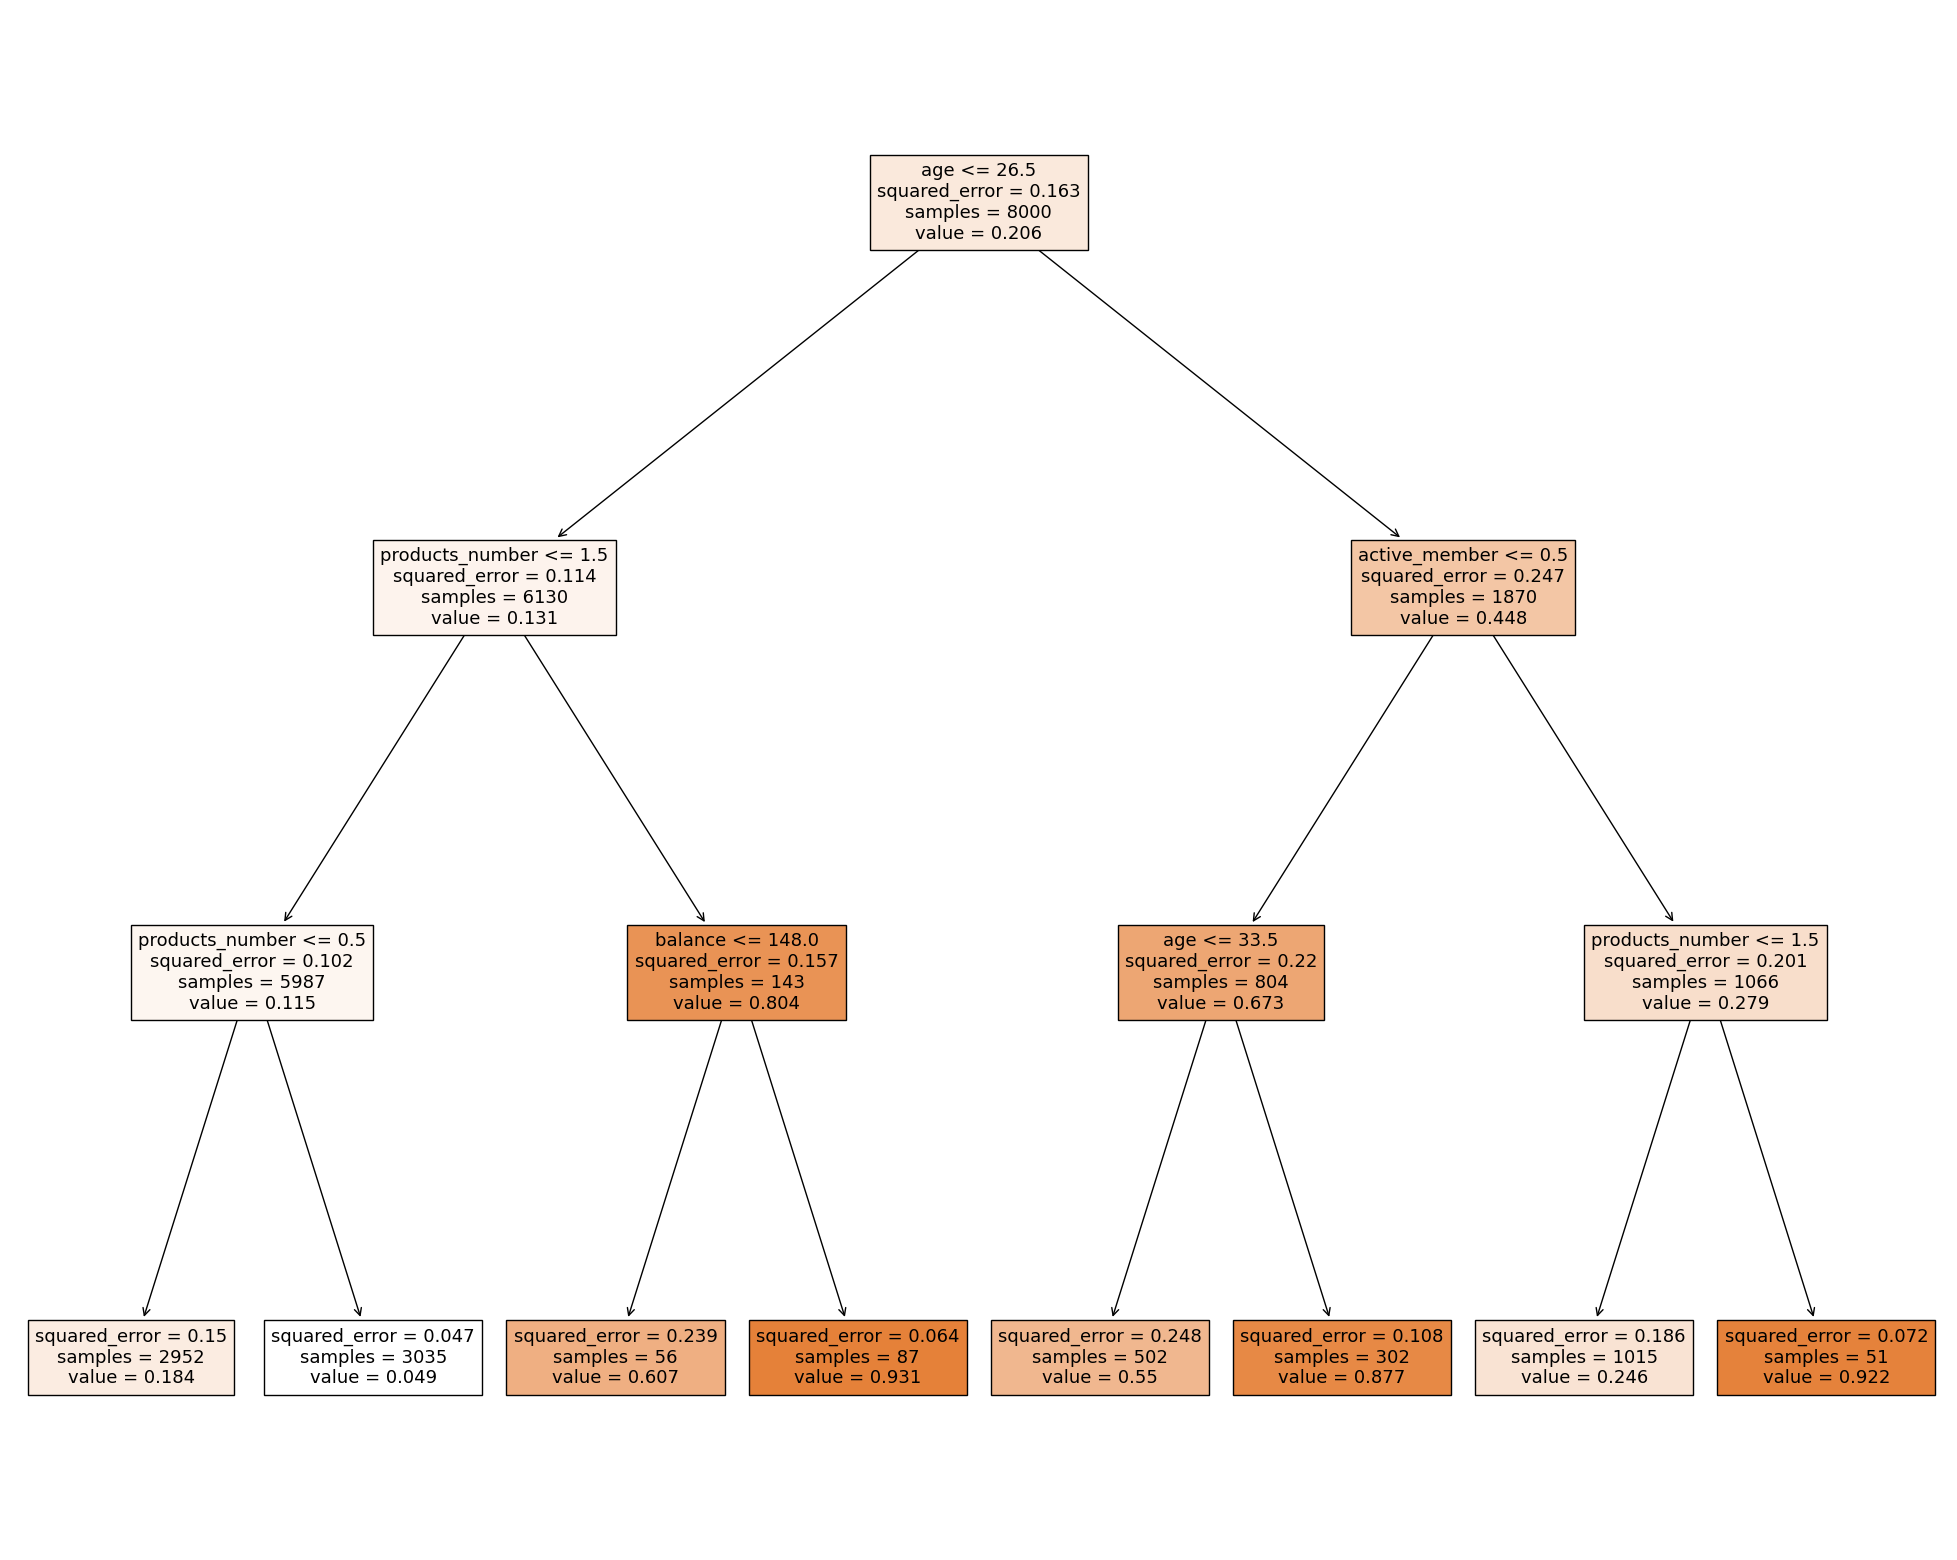

In [201]:
from sklearn import tree
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(25,20))
tree.plot_tree(DTree, feature_names= features.columns, filled=True)

The max_depth of the tree is set at 3. With each note, the data is being split into smaller subset. Node 0 has all samples of the dataset, but it'll be lower by the Node 3. Node 0 - age - took 8000 samples to arrive at value of 0.26. Node 2 and Node 3 - products_number,  active_member - took 6130 and 1870 samples to set a bracket for products_number, balance and age and further the leaves of the tree has a bracket for mse, wherein each mse bracket is given a value.

# Q3. Fit a linear model and interpret the regression coefficients

In [202]:
!pip install h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.6/265.6 MB 2.4 MB/s eta 0:00:00


In [204]:
import h2o
from h2o.automl import H2OAutoML

In [205]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.22" 2024-01-16; OpenJDK Runtime Environment (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1); OpenJDK 64-Bit Server VM (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpxbcz3pzn
  JVM stdout: /tmp/tmpxbcz3pzn/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpxbcz3pzn/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,4 days
H2O_cluster_name:,H2O_from_python_unknownUser_byahnc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [206]:
from h2o.automl import H2OAutoML

In [207]:
df_auto = h2o.import_file('https://raw.githubusercontent.com/anshvaghela2099/INFO6105_DSEM/main/Bank_Customer_Churn_Prediction.csv')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [208]:
df_auto.head(5)

customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
1.56346e+07,619,France,Female,42,2,0,1,1,1,101349,1
1.56473e+07,608,Spain,Female,41,1,83807.9,1,0,1,112543,0
1.56193e+07,502,France,Female,42,8,159661,3,1,0,113932,1
1.57014e+07,699,France,Female,39,1,0,2,0,0,93826.6,0
1.57379e+07,850,Spain,Female,43,2,125511,1,1,1,79084.1,0


# Splitting train test and vailidation into 70:15:15 ratio

In [210]:
train,test,valid = df_auto.split_frame(ratios=[.7, .15])

In [212]:
y = "churn"
x = df_auto.columns
x.remove(y)
x.remove("customer_id")

Here the target feature is churn for binary classification.

Removing customer_id as customer id is just unique identifier that is randomly allocated to a customer and does not contribute for our analysis

In [213]:
aml = H2OAutoML(max_models = 10, seed = 10, exclude_algos = ["StackedEnsemble", "DeepLearning"], verbosity="info", nfolds=0)

In [214]:
aml.train(x = x, y = y, training_frame = train, validation_frame=valid)

AutoML progress: |
03:14:25.150: Project: AutoML_1_20240318_31425
03:14:25.152: Cross-validation disabled by user: no fold column nor nfolds > 1.
03:14:25.152: Setting stopping tolerance adaptively based on the training frame: 0.01197626261913259
03:14:25.153: Build control seed: 10
03:14:25.154: training frame: Frame key: AutoML_1_20240318_31425_training_py_3_sid_8acf    cols: 12    rows: 6972  chunks: 8    size: 147080  checksum: 2566917334790976214
03:14:25.167: validation frame: Frame key: py_5_sid_8acf    cols: 12    rows: 1495  chunks: 8    size: 45758  checksum: 6665068269392575394
03:14:25.169: leaderboard frame: Frame key: py_5_sid_8acf    cols: 12    rows: 1495  chunks: 8    size: 45758  checksum: 6665068269392575394
03:14:25.170: blending frame: NULL
03:14:25.175: response column: churn
03:14:25.175: fold column: null
03:14:25.176: weights column: null
03:14:25.242: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_

,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,45.0,45.0,34674.0,7.0,7.0,7.0,26.0,91.0,56.622223
,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2024-03-18 03:14:43,0.004 sec,0.0,0.3997416,0.3195867,0.1597933,0.4025036,0.3218025,0.1620091
,2024-03-18 03:14:43,0.260 sec,5.0,0.3454302,0.2702138,0.1193220,0.3514278,0.2750999,0.1235015
,2024-03-18 03:14:43,0.466 sec,10.0,0.3203884,0.2405808,0.1026488,0.3312655,0.2489673,0.1097368
,2024-03-18 03:14:44,0.635 sec,15.0,0.3060570,0.2210454,0.0936709,0.3217255,0.2323518,0.1035073
,2024-03-18 03:14:44,0.827 sec,20.0,0.2971141,0.2062220,0.0882768,0.3179981,0.2210832,0.1011228
,2024-03-18 03:14:44,0.955 sec,25.0,0.2909735,0.1965347,0.0846656,0.3164056,0.2139207,0.1001125
,2024-03-18 03:14:44,1.085 sec,30.0,0.2865664,0.1891481,0.0821203,0.3156017,0.2086504,0.0996044
,2024-03-18 03:14:44,1.245 sec,35.0,0.2838003,0.1846993,0.0805426,0.3147696,0.2051233,0.0990799


# Training the AutoML with training data

In [215]:
lb = aml.leaderboard

In [216]:
best_model = aml.get_best_model()

In [217]:
print(best_model)

Model Details
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_2_AutoML_1_20240318_31425


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    45                 45                          34674                  7            7            7             26            91            56.6222

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.07791295489480436
RMSE: 0.27912892163802083
MAE: 0.17924682722116025
RMSLE: 0.19460458808103248
Mean Residual Deviance: 0.07791295489480436

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 0.09939449267223474
RMSE: 0.31526892119623007
MAE: 0.203077019217779
RMSLE: 0.2215211026660241
Mean Residual Deviance: 0.099394492672

In [218]:
lb.head()

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GBM_2_AutoML_1_20240318_31425,0.315269,0.0993945,0.203077,0.221521,0.0993945
GBM_3_AutoML_1_20240318_31425,0.317566,0.100848,0.204957,0.223982,0.100848
GBM_1_AutoML_1_20240318_31425,0.320047,0.10243,0.210893,0.225312,0.10243
DRF_1_AutoML_1_20240318_31425,0.32306,0.104367,0.207444,0.228625,0.104367
XGBoost_3_AutoML_1_20240318_31425,0.323268,0.104502,0.208055,0.22783,0.104502
GBM_4_AutoML_1_20240318_31425,0.324852,0.105529,0.209234,0.229382,0.105529
XRT_1_AutoML_1_20240318_31425,0.334127,0.111641,0.242975,0.238708,0.111641
XGBoost_2_AutoML_1_20240318_31425,0.348403,0.121384,0.234035,0.250792,0.121384
XGBoost_1_AutoML_1_20240318_31425,0.352518,0.124269,0.244214,0.257082,0.124269
GLM_1_AutoML_1_20240318_31425,0.371465,0.137986,0.281967,0.261157,0.137986


#### **Observations on best model:**
 **Gradient Boosting Machine** is the best performing model with model key *GBM_3_AutoML_12_20230227_23505*

`age` has the highest relative_importance with respect to the target feature `churn` and followed by `product_number`

# **Q4. Run SHAP analysis on the models from steps 1, 2, and 3, interpret the SHAP values and compare them with the other model interpretability methods.**


In [219]:
!pip3 install shap

In [220]:
import shap

# 1. Shap Analysis of the Linear Model

/usr/local/lib/python3.10/dist-packages/shap/explainers/_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


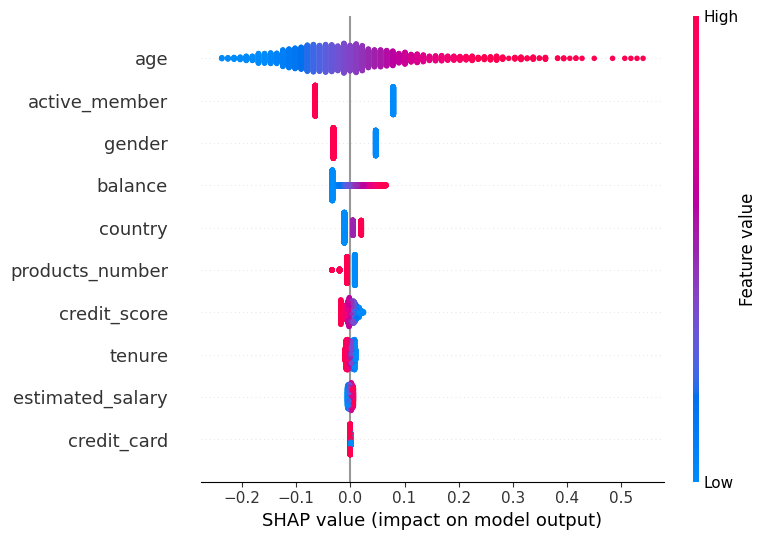

In [221]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

explainer_sh = shap.LinearExplainer(lin_reg, X_train, feature_perturbation='interventional',feature_names=features.columns)
shap_values_lg = explainer_sh.shap_values(X_test)
shap.summary_plot(shap_values_lg, X_test, feature_names=features.columns)

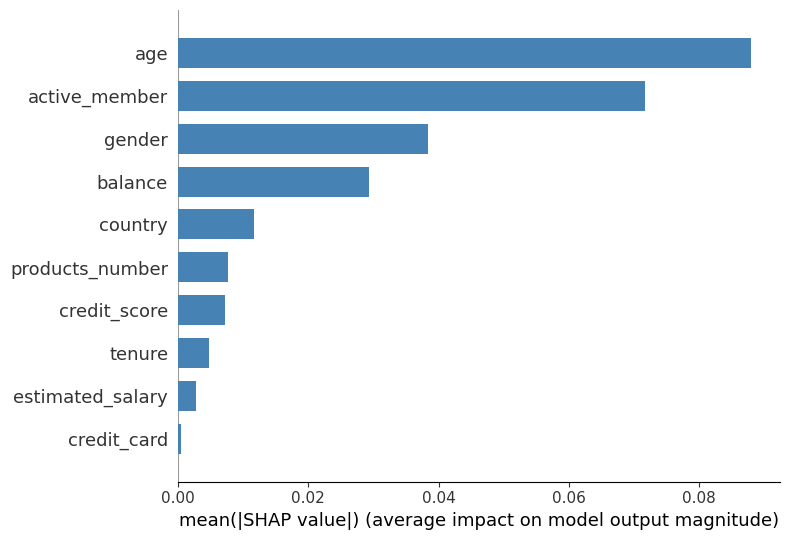

In [222]:
shap.summary_plot(shap_values_lg, X_train, plot_type="bar", color='steelblue')

The age and active_member variable shows high importance than other features in predicting the churn feature

# 2. Tree Model - Shap Analysis

In [223]:
explainer_tree = shap.Explainer(DTree)
shap_values_tree = explainer_tree(X_test)

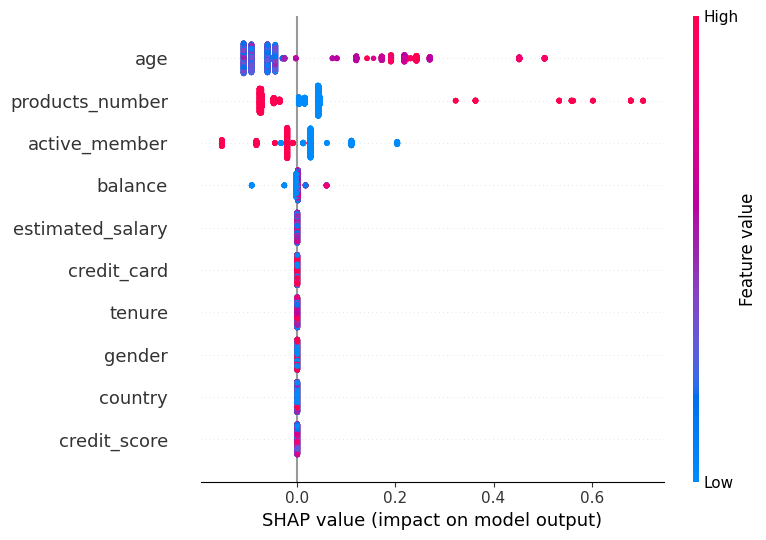

In [224]:
shap.summary_plot(shap_values_tree, X_test, feature_names=features.columns)

The tree model suggests that age and product_number are more signifiacnt whereas in linear regression, age and active_member were the most significant features.

# 3. AutoML - Shap Analysis

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,rmse,mse,mae,rmsle,mean_residual_deviance,training_time_ms,predict_time_per_row_ms,algo
GBM_2_AutoML_1_20240318_31425,0.327702,0.107388,0.210805,0.227102,0.107388,1528,0.029668,GBM
DRF_1_AutoML_1_20240318_31425,0.328604,0.10798,0.211224,0.229431,0.10798,5069,0.035287,DRF
GBM_3_AutoML_1_20240318_31425,0.328612,0.107986,0.213136,0.228481,0.107986,942,0.075487,GBM
GBM_1_AutoML_1_20240318_31425,0.330125,0.108982,0.217452,0.229257,0.108982,2618,0.029355,GBM
GBM_4_AutoML_1_20240318_31425,0.330797,0.109427,0.214674,0.23044,0.109427,1123,0.02796,GBM
XGBoost_3_AutoML_1_20240318_31425,0.332834,0.110778,0.217124,0.231857,0.110778,2283,0.011163,XGBoost
XGBoost_2_AutoML_1_20240318_31425,0.346602,0.120133,0.232152,0.247304,0.120133,2217,0.016854,XGBoost
XRT_1_AutoML_1_20240318_31425,0.349943,0.12246,0.254195,0.247023,0.12246,3686,0.046617,DRF
XGBoost_1_AutoML_1_20240318_31425,0.356118,0.12682,0.248824,0.256814,0.12682,6845,0.022399,XGBoost
GLM_1_AutoML_1_20240318_31425,0.383955,0.147422,0.292674,0.26775,0.147422,671,0.01079,GLM


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

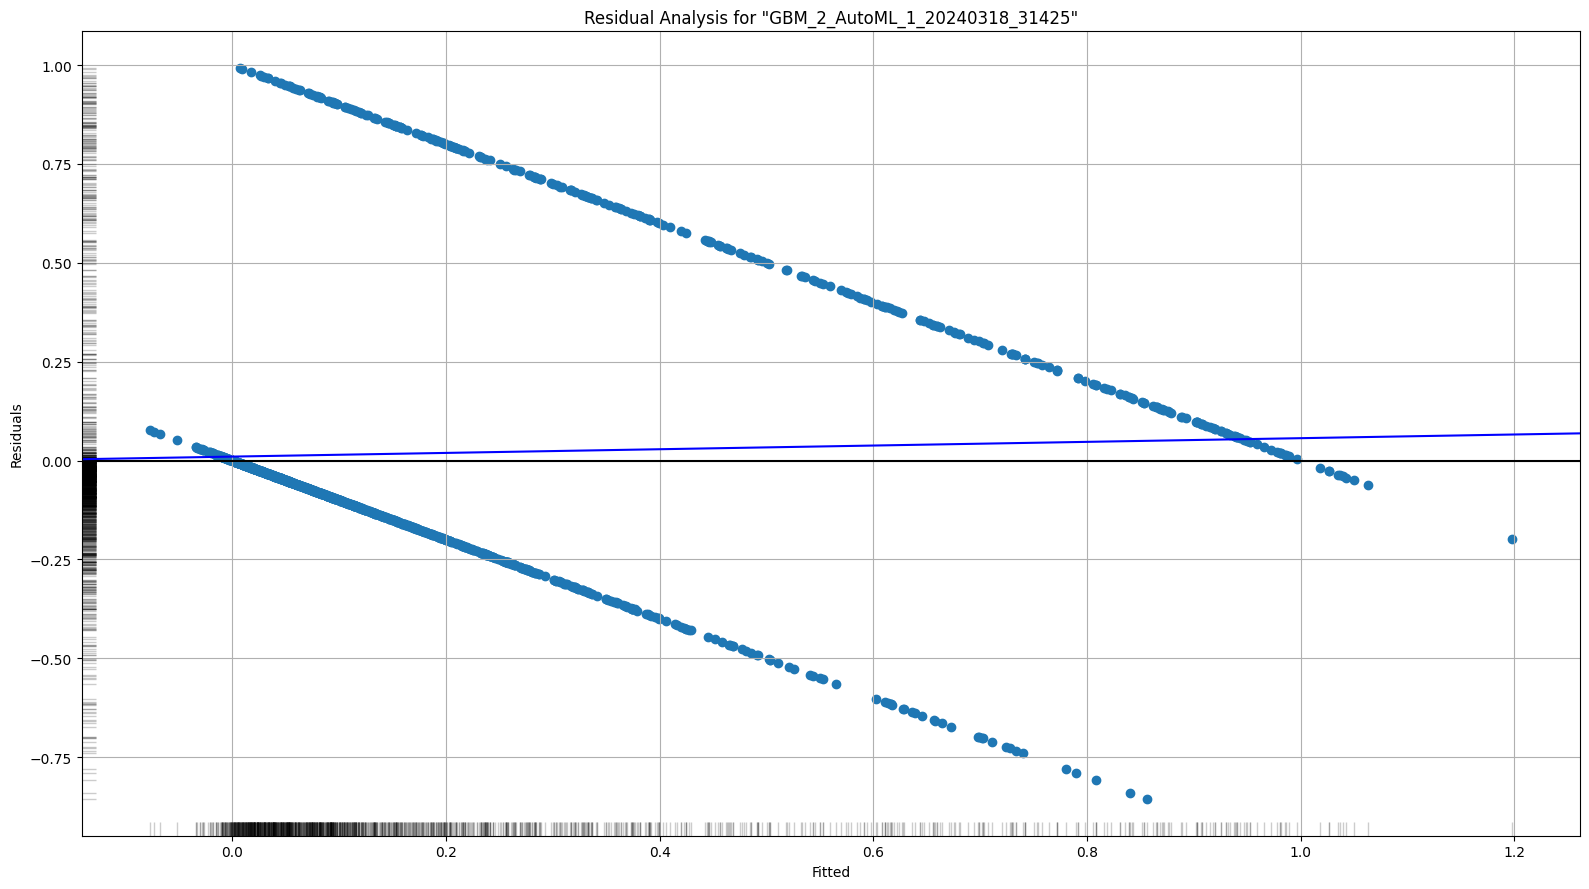

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

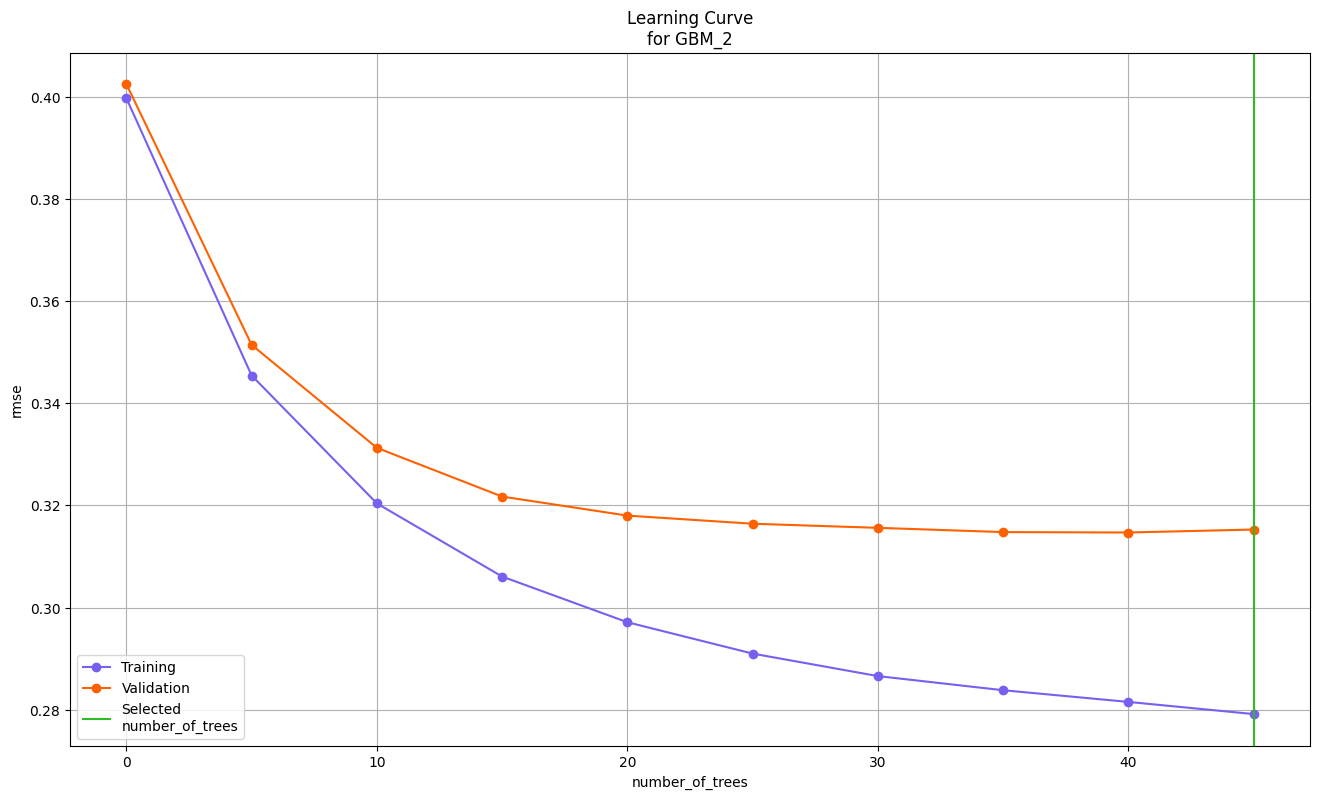

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

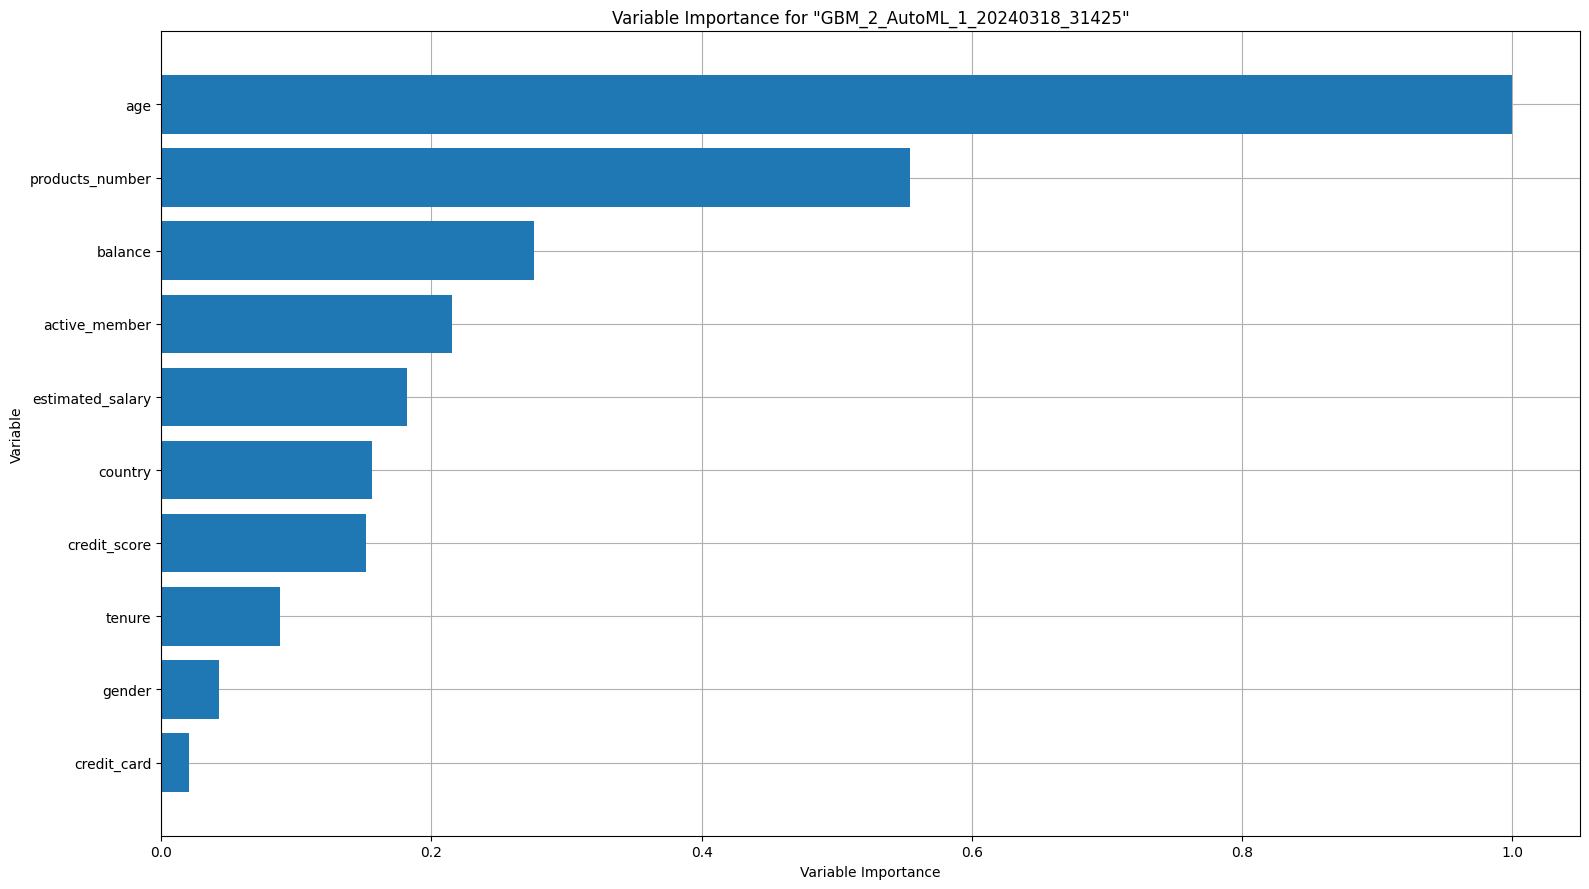

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

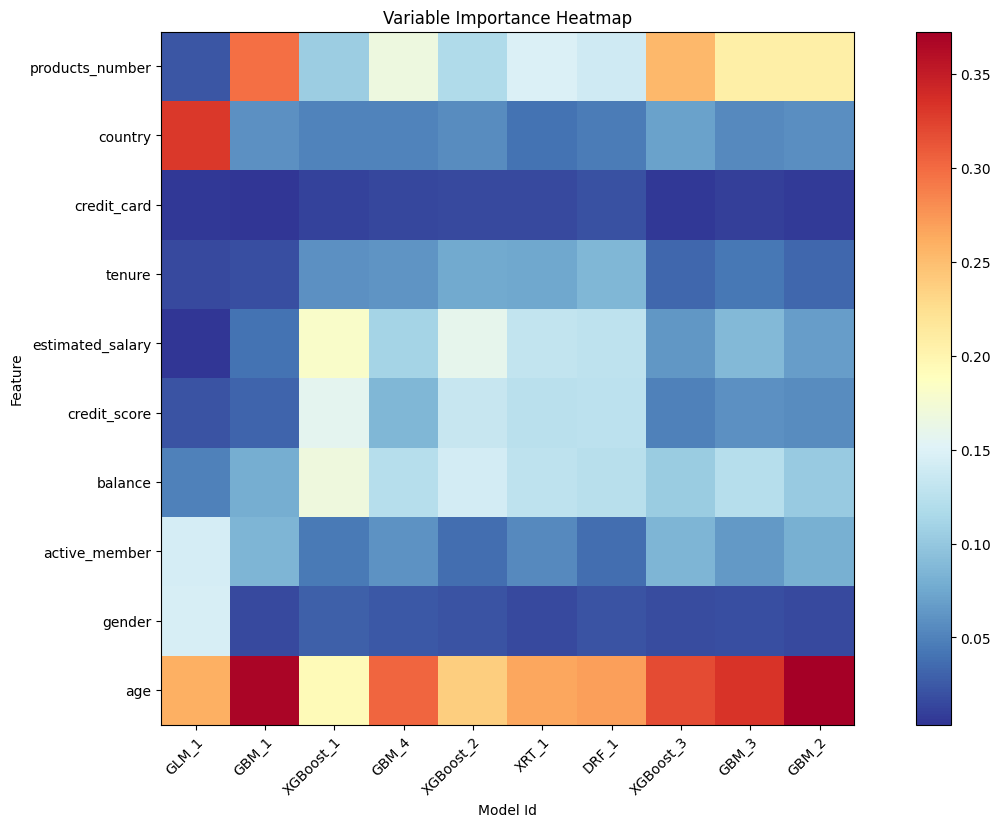

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

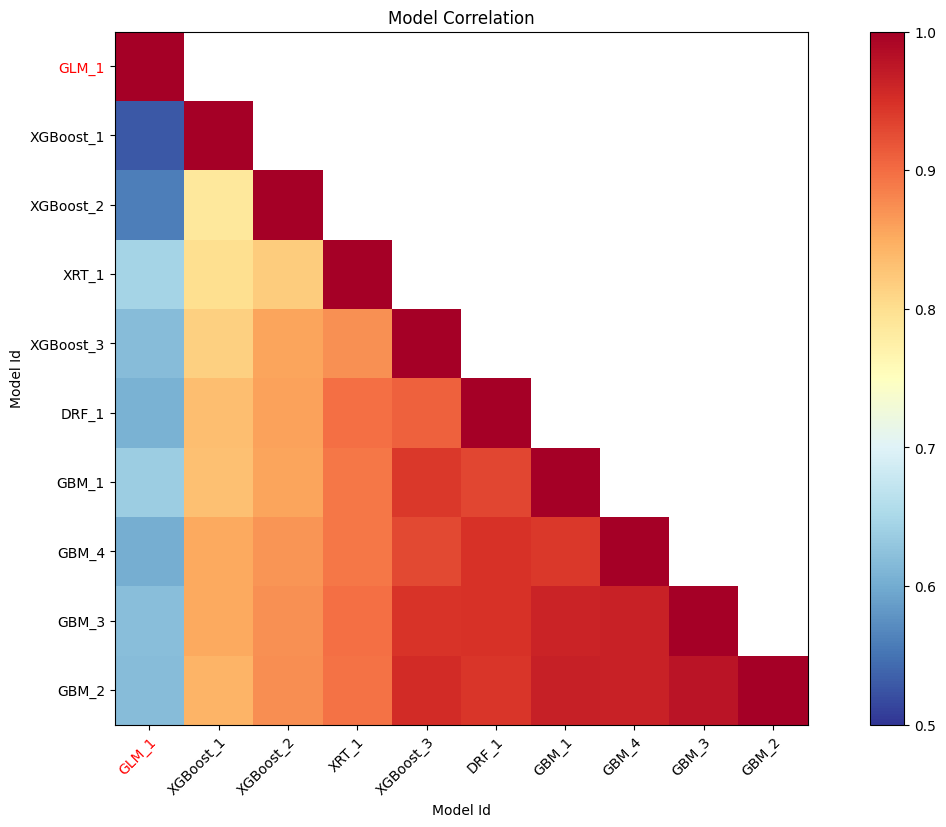

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

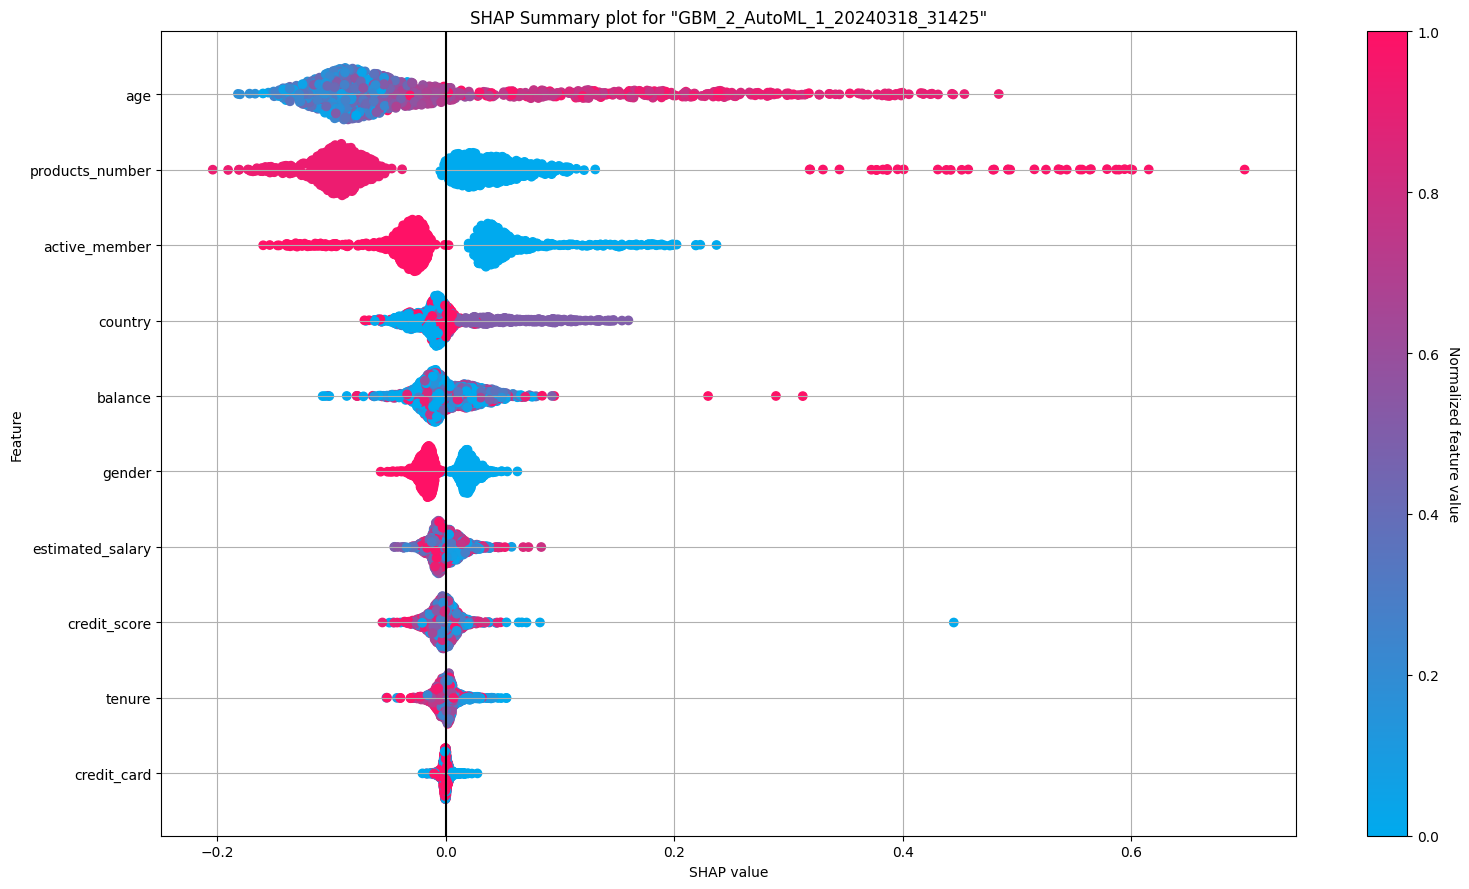

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

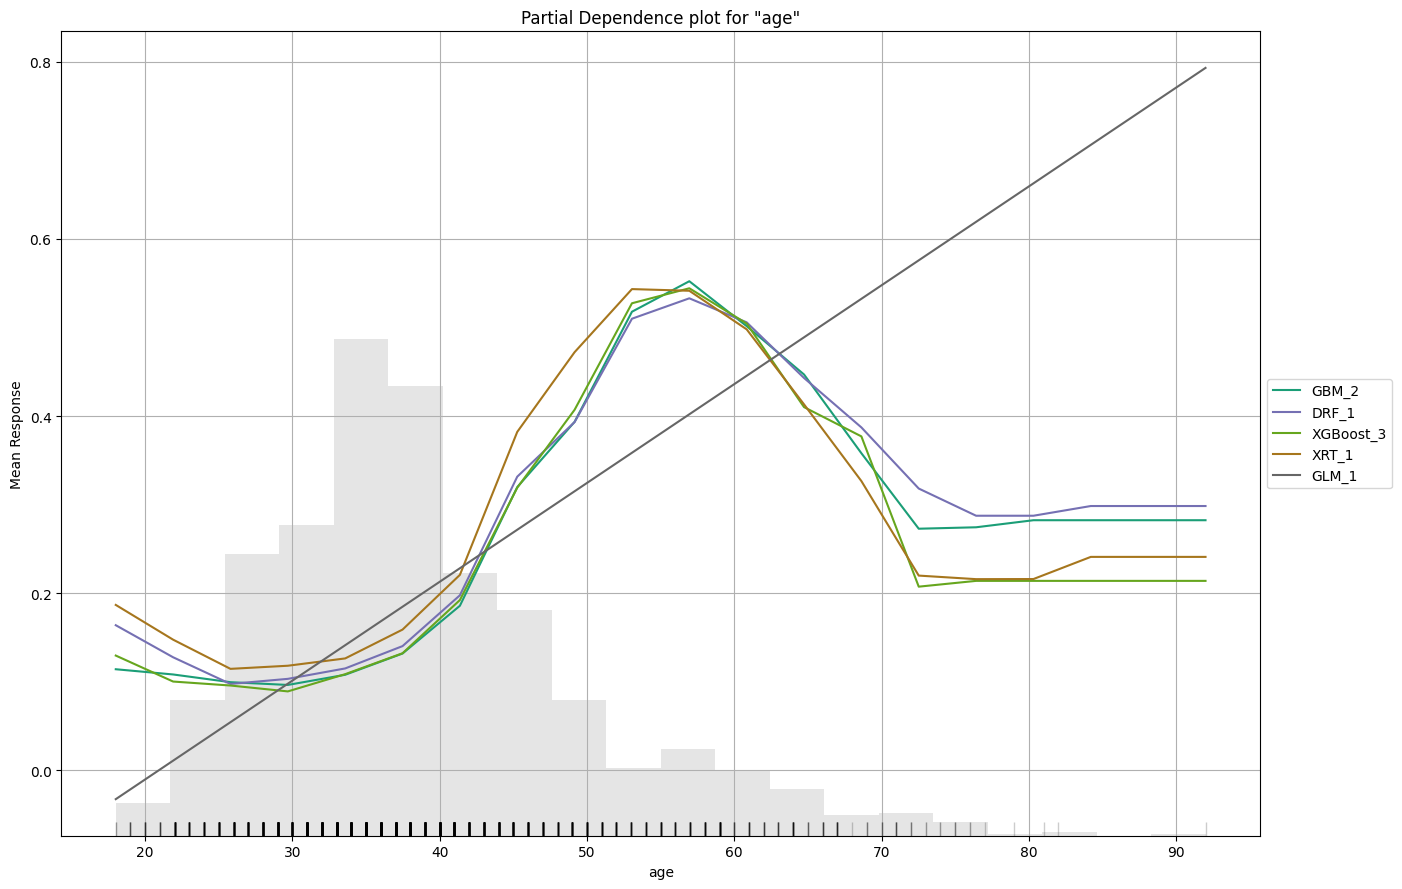

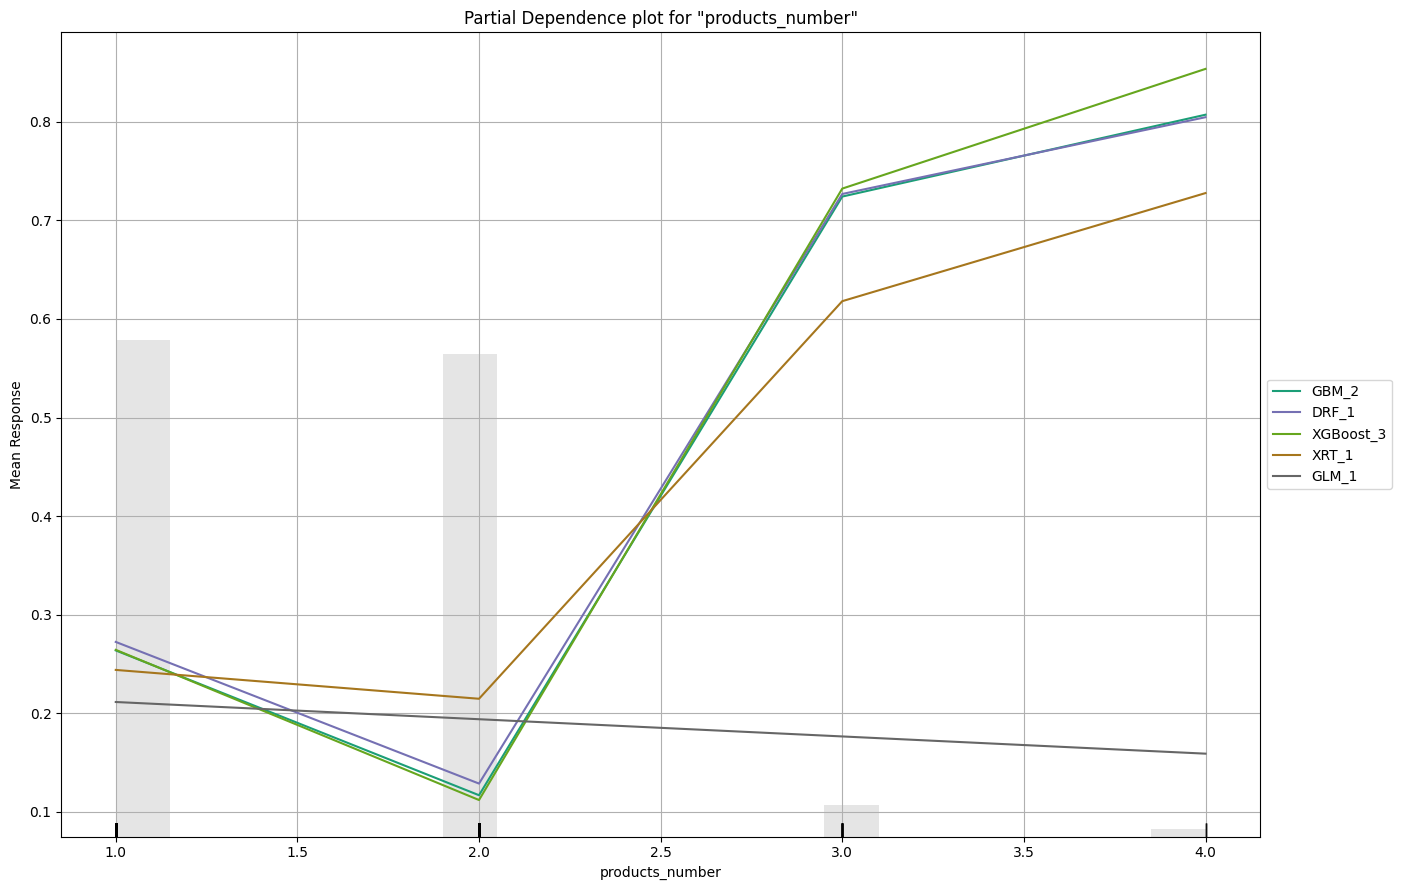

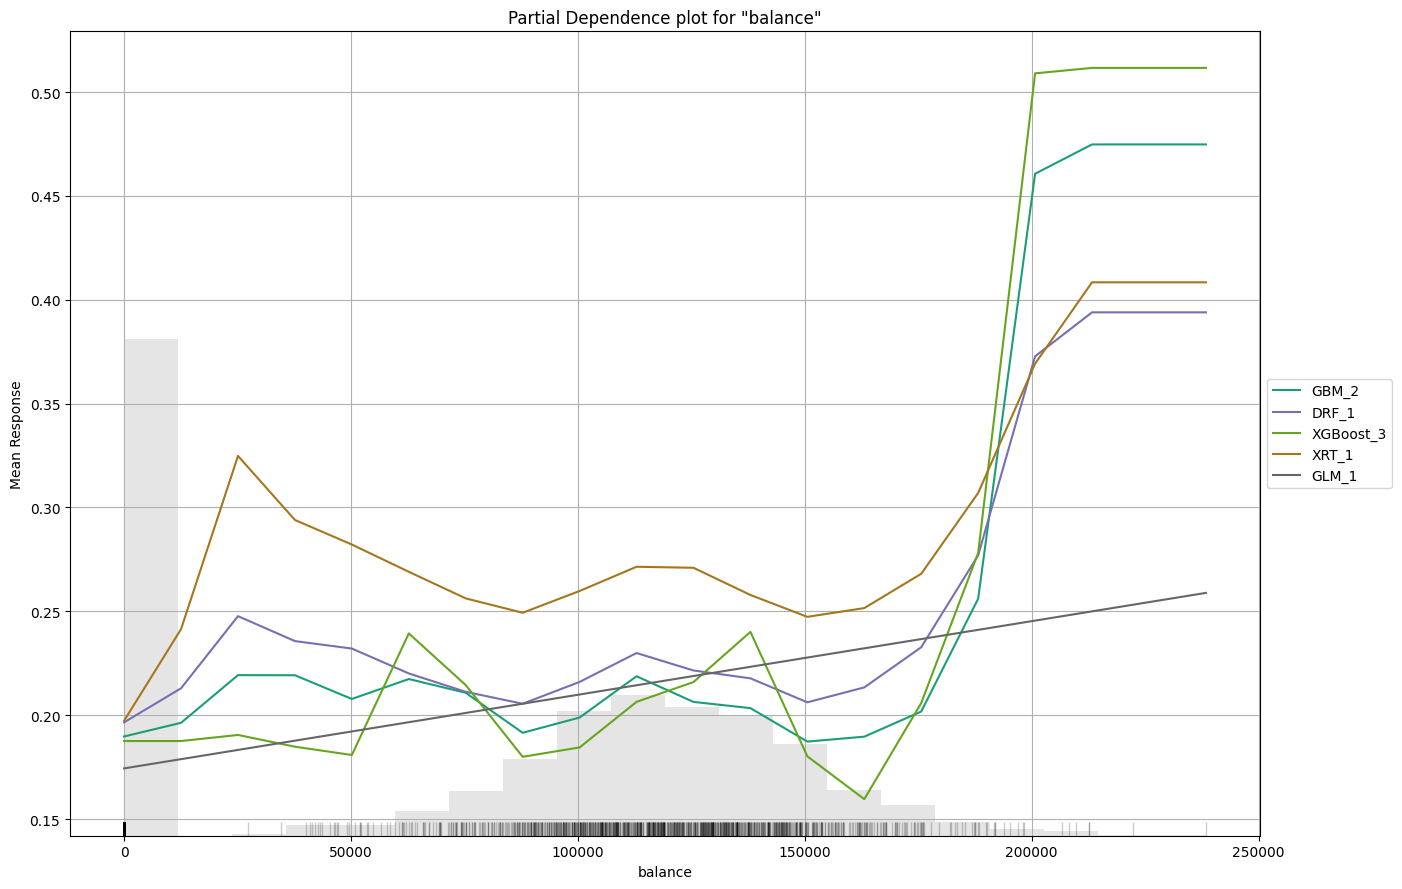

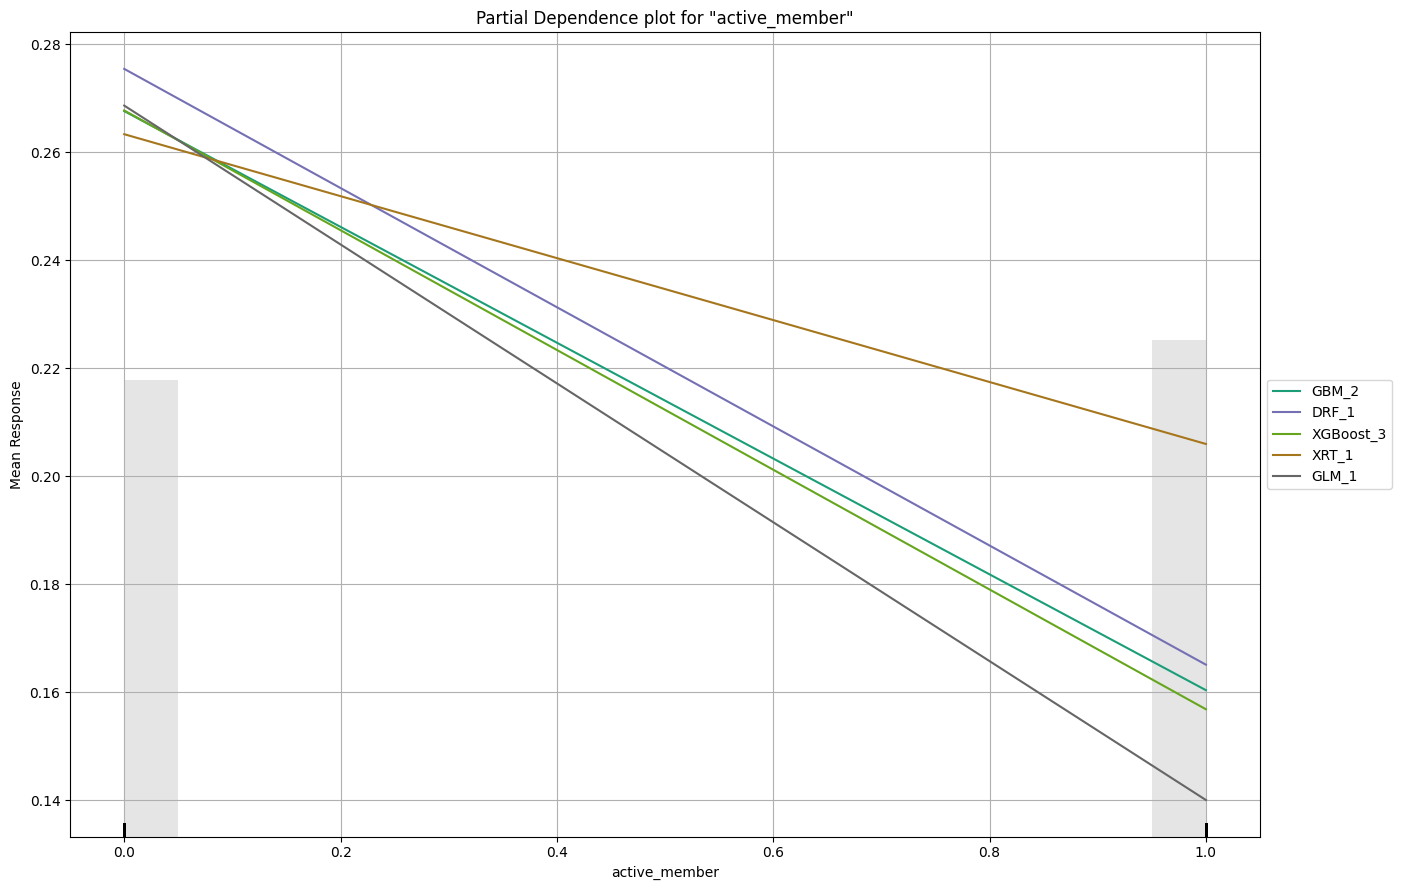

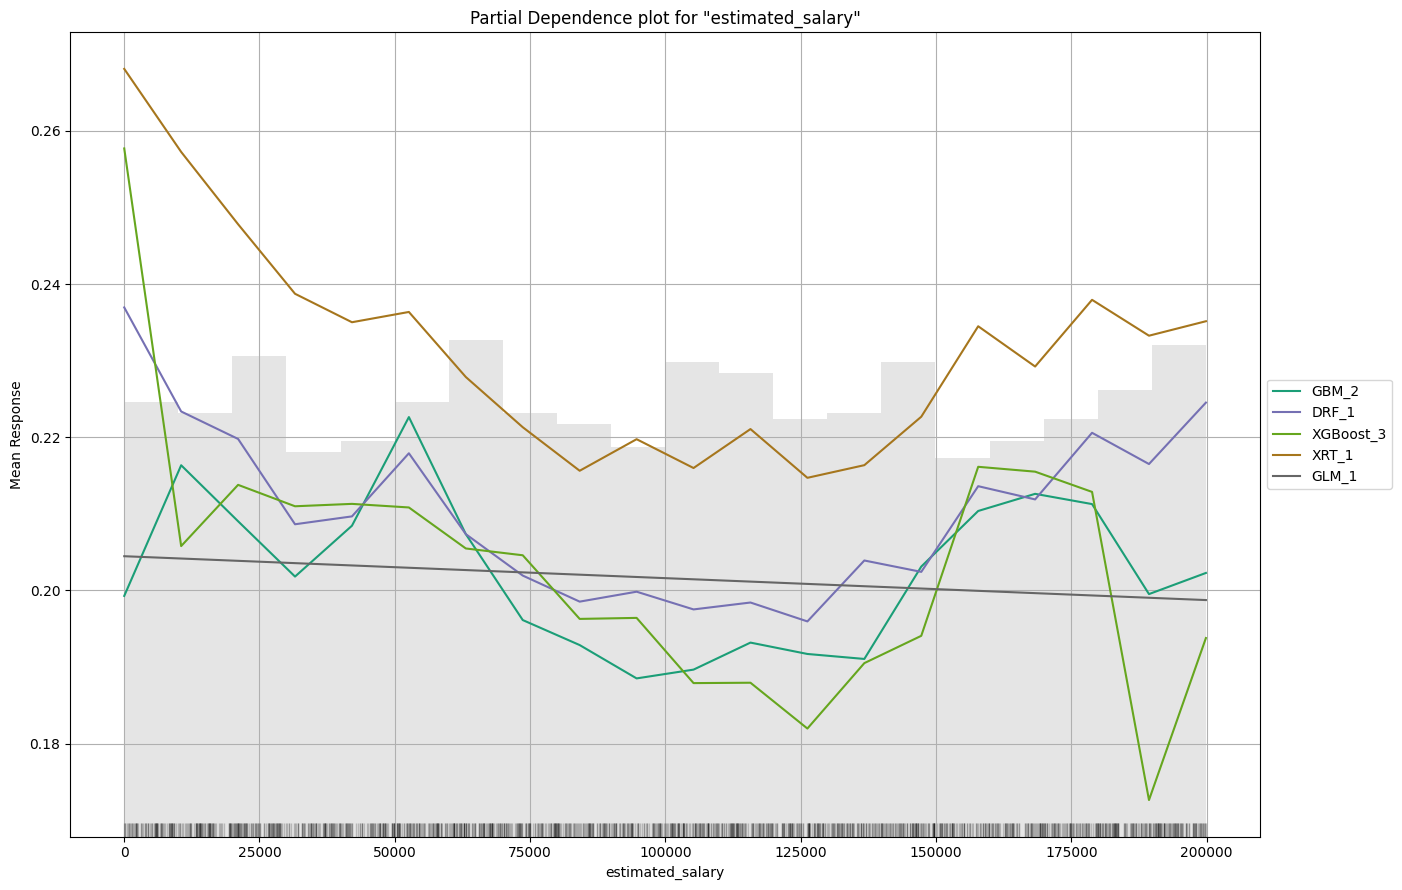

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

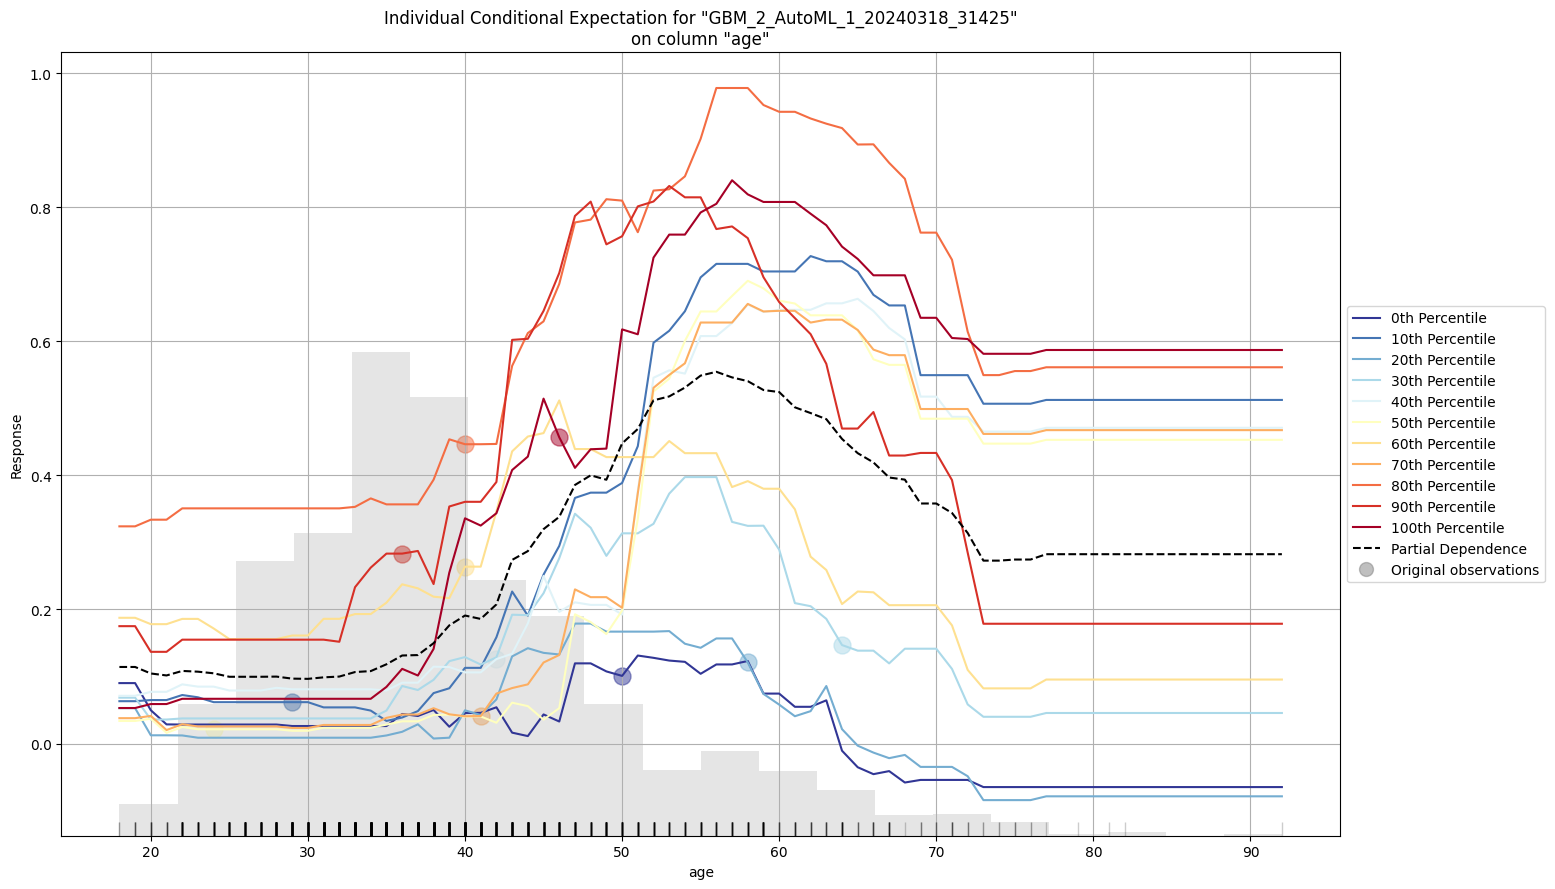

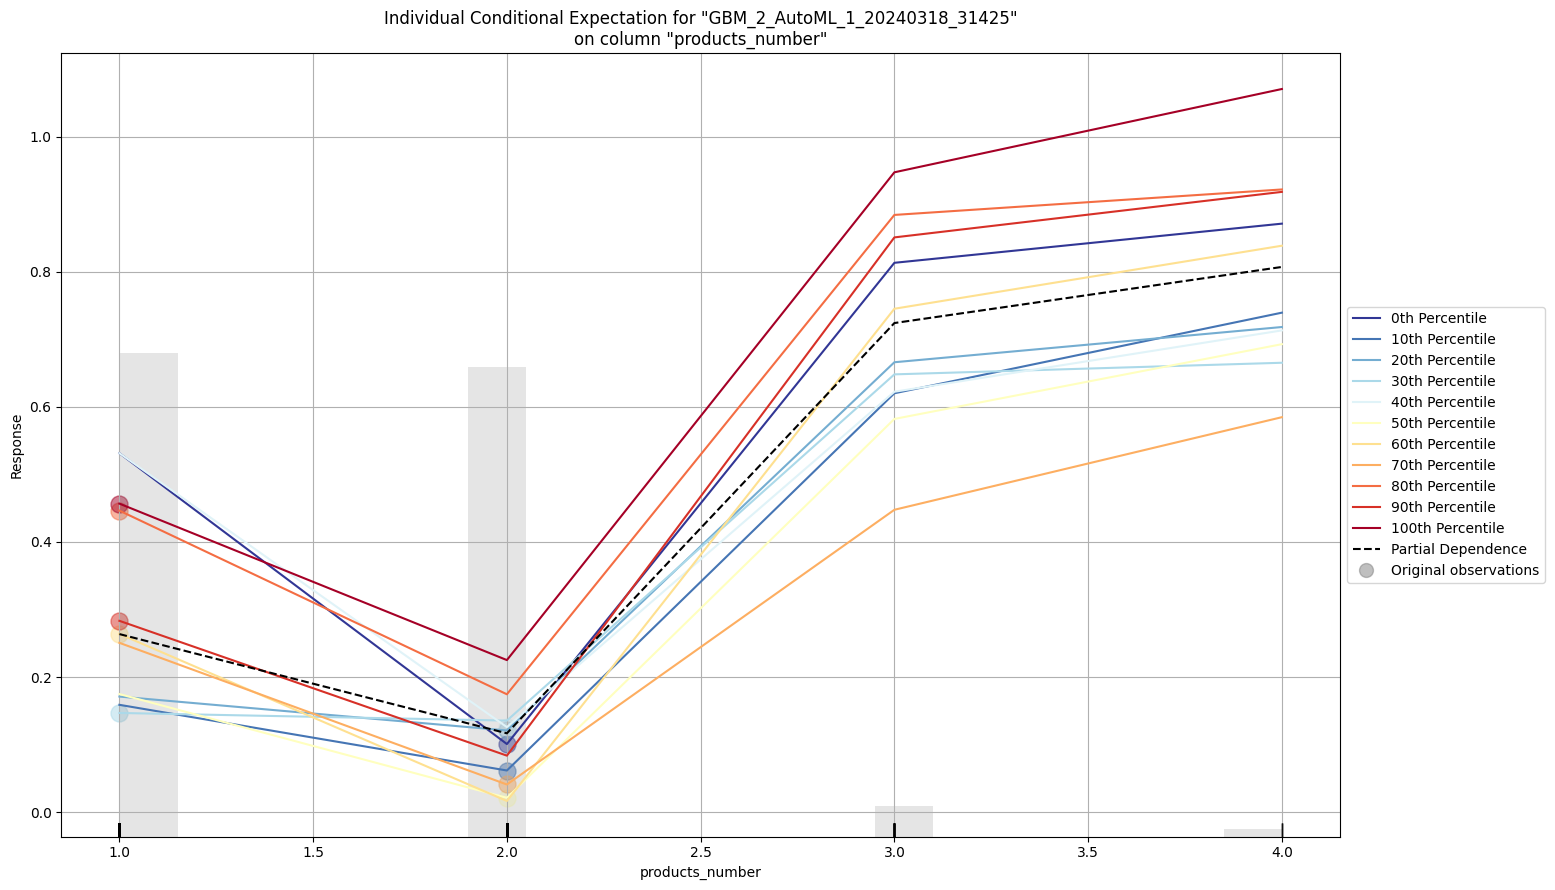

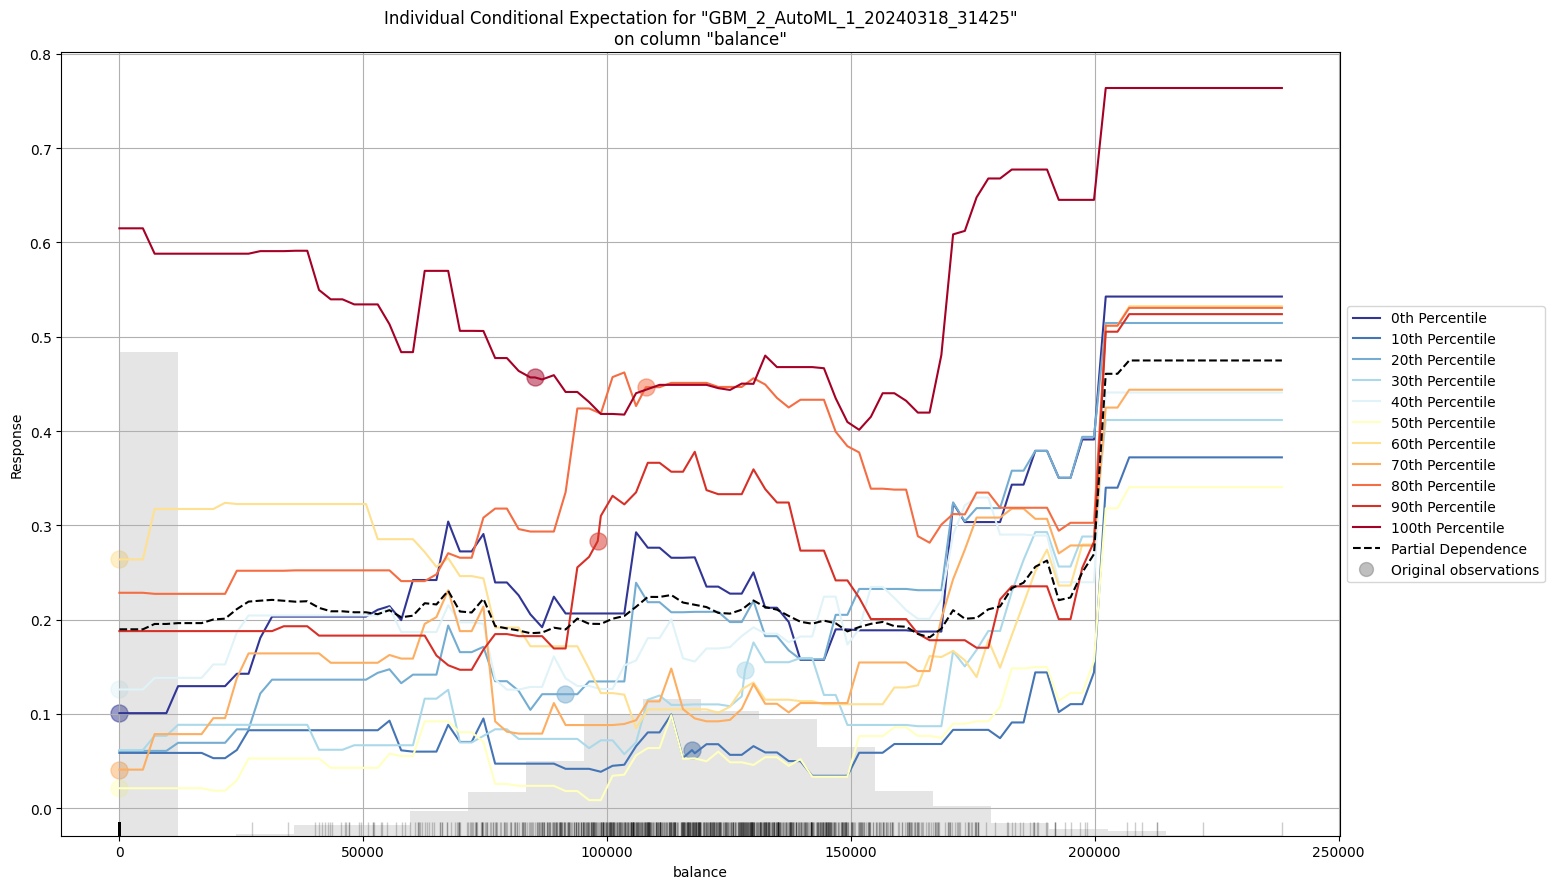

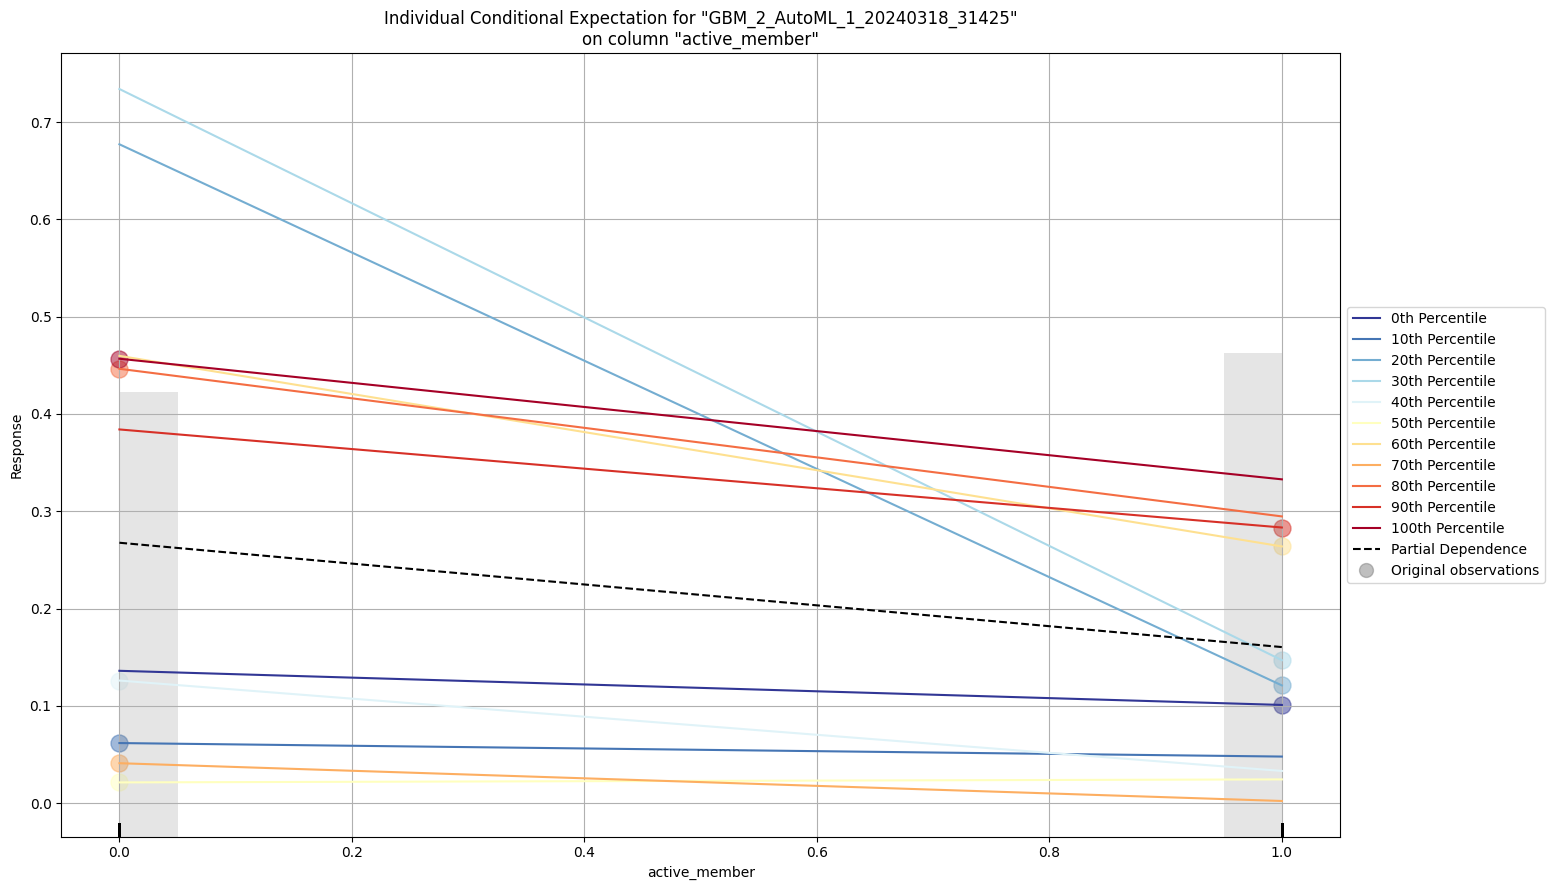

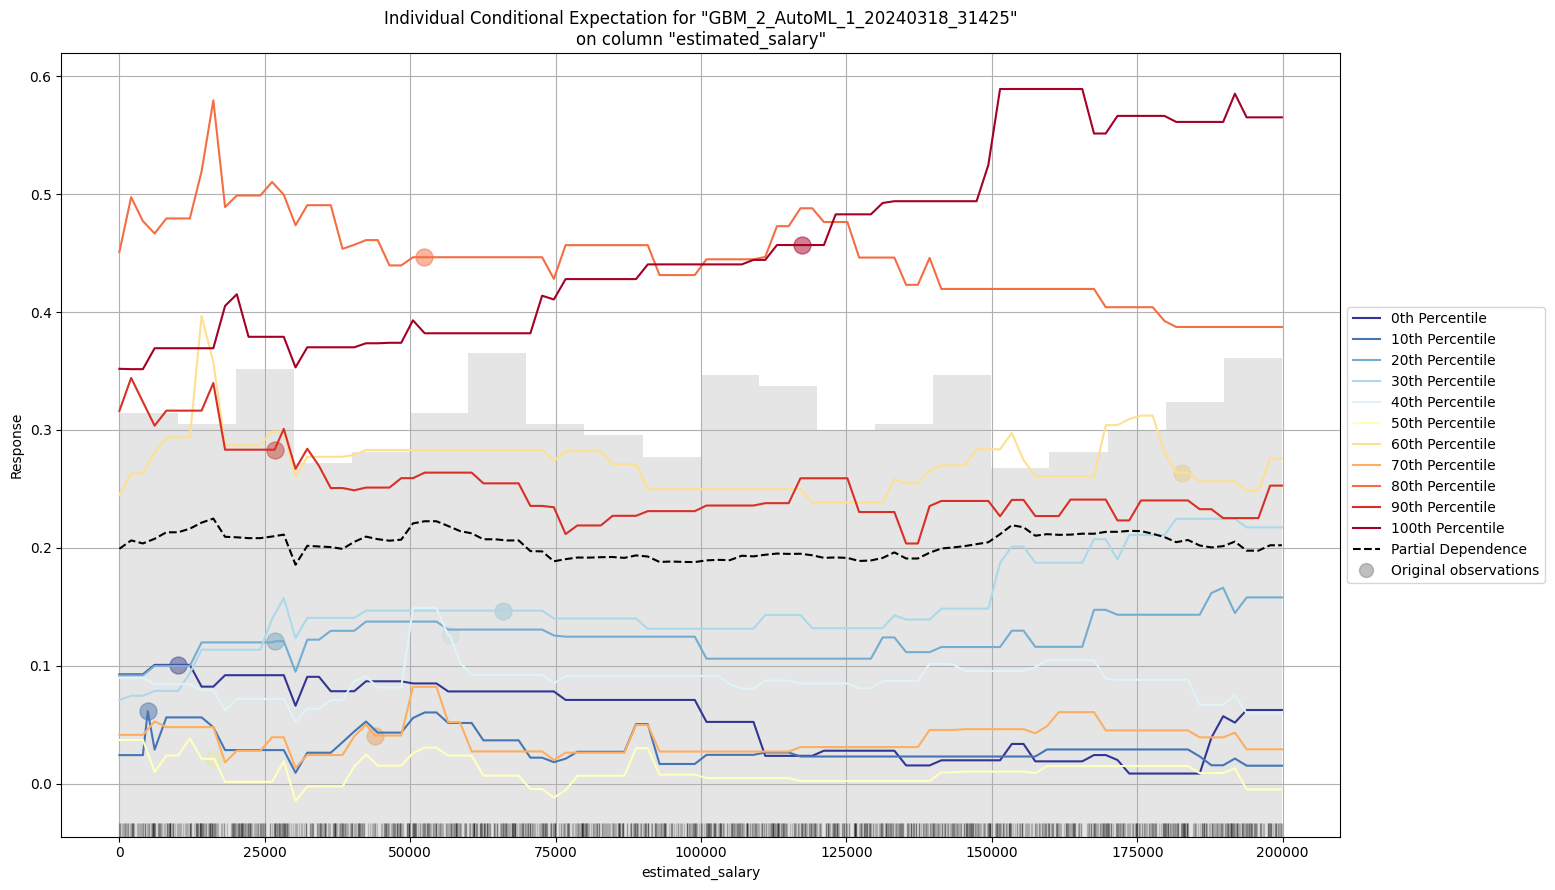

In [225]:
exm = aml.explain(test)

**From Variable importance graph**

age shows high importance in predicting the target varible churn. Its very high showing colinearity

credit_card of has no much importance in predicting target i.e churn


**From Shap Analysis**

Except age and product_number other features doesn't show high variation in the impact on target variable

# Conclusion
In Linear model, SHAP abalysis shows similar inference like the feature importance approaches like OLS regression

In a treebased model the inferences from feature importance and SHAP are almost same how ever they are a bit different on same traget variable comparing to linear modeling

SHAP helps us in understanding the importance of a feature in a row level and fairly showing the population density at that instant

for churn variable different models showed different impact on the same target
In a tree based model age and product_number showed high importance on churn while other models showed active_member as an important feature over every other

# References and License

https://stackoverflow.com/questions/66324765/get-accuracy-metric-from-leaderboard-function-when-using-h20-ai/66325195#66325195

medium: towardsdatascience

geeksforgeeks

https://docs.h2o.ai/

Assignment_1_ML_Data_Cleaning_and_Feature_Selection.ipynb

Assignment2-AutoML-Ansh.ipynb

https://github.com/ajhalthor/model-interpretability/blob/main/Shap%20Values.ipynb

https://www.analyticsvidhya.com/blog/2021/11/model-explainability/

https://docs.h2o.ai/h2o/latest-stable/h2o-docs/explain.html

MIT License

Copyright (c) 2024 anshvaghela2099

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.